# Authorship Verification

## Preprocessing

Loading the needed libraries:

In [1]:
import lxml.etree
import os
from string import punctuation
import pandas as pd
import nltk as nlp
import re
from pathlib import Path
import numpy as np

from tqdm import tqdm

First, a function is created to iterate over the obtained TEI files from the *Cd-rom* and to convert them to txt files.

We start by having a look at the file directly obtained from the *Cd-rom*.

In [2]:
with open('cdrom'+os.sep+'rose.xml') as stream: # "with open" is safer to use, since it closes by itself
    xml = stream.read() # open txt file and read the text
print(xml)

<?xml version='1.0'?><!DOCTYPE TEI.2 PUBLIC '-//TEI P4//DTD Main Document Type//EN' 'http://www.tei-c.org/Guidelines/DTD/tei2.dtd' [<!ENTITY % TEI.transcr 'INCLUDE'> <!ENTITY % TEI.prose 'INCLUDE'><!ENTITY % TEI.linking 'INCLUDE'><!ENTITY % TEI.figures 'INCLUDE'><!ENTITY % TEI.analysis 'INCLUDE'><!ENTITY % TEI.corpus 'INCLUDE'><!ENTITY % TEI.XML 'INCLUDE'><!NOTATION TEI-XML PUBLIC 'TEI P4' 'http://www.tei-c.org/Guidelines/DTD/tei2.dtd'>]><TEI.2><teiHeader>
<fileDesc>
<titleStmt>
<title>Rose</title>
<author>Hein van Aken</author>
</titleStmt>
<editionStmt>
<edition>E. Verwijs (ed.): Die Rose van Heinric van Aken, met de fragmenten der tweede vertaling, van wege de Maatschappij der Nederlandsche Letterkunde te Leiden uitgegeven door dr. Eelco Verwijs. 'sGravenhage, 1868.</edition>
</editionStmt>
<publicationStmt>
<p></p>
</publicationStmt>
<sourceDesc>
<listBibl id="inlMetadata">
<bibl><interpGrp type="titleLevel1">
<interp value="Rose"/>
</interpGrp><interpGrp type="medium">
<interp val

We create functions to lowercase and delete the punctuation.

In [3]:
def lowercasing (text):
    return text.lower()

In [4]:
def delete_punct (text):
    for character in text:
        if character in punctuation:
            text = text.replace(character, '') # if the character is present in the punctuation string, replace it with nothing (delete)
    return text

We create a function to retrieve the author out of the original xml file. This will be used to put the author in the file name later on (so that it can be easily retrieved after manipulating the contents of the file).

In [5]:
def get_author (path):
    tree = lxml.etree.parse(path)
    for author in tree.iter('author'): # iterate over every 'author' element
        author = ''.join(author.itertext())
        author = delete_punct(author) # deleting possible punctuation
        author = lowercasing(author) # lowercasing all characters
        author = author.replace(" ", "_")
        author = "-" + author # making it ready to 'paste' to the title
        return author

We create the function that retrieves only the verses from the TEI files. It has the option to lowercase and to delete punctuation.

In [6]:
# return only the lines of the file that we need (element 'l')

def return_lines (path, lowercase=True, no_punct=True ):
    tree = lxml.etree.parse(path)
    lines = [] # define an empty list
    text = ""
    for verse in tree.iter('l'): # iterate over every 'l' element
        line = ''.join(verse.itertext())
        lines.append(str(line)) # append all 'l' elements to the list
    text = '\n'.join(lines) # join the items of the list with a new line character

    
    # accounting for the different options of arguments
    if lowercase == True and no_punct == False:
        return lowercasing(text)
    if lowercase == False and no_punct == True:
        return delete_punct(text)
    if lowercase == True and no_punct == True:
        text = lowercasing(text)
        return delete_punct(text)
    else:
        return text

In [7]:
test = return_lines('cdrom'+os.sep+'rose.xml', lowercase=True, no_punct=True)
test

'het seit menech dat in drome\nniet el en es dan idele gome\nlogene ende ongewarechede\nnochtan heeft men ter meneger stede\ndicke die drome vonden waer\nende die dinc gescien daer naer\nalsi in drome waren gesien\nso wie dat wille houden in dien\ndat ic doer ben ende sot\nine houde drome niet over spot\nmen hefse dicke waer ondervonden\nalse wi horen wel orconden\nenen auctoer die macrobes hiet\nhine houtse over logene niet\ndie bescreef dat vision\nvanden coninc scipion\nte minen rechten xx jaren\nalse minne neemt al sonder sparen\nvan jongen lieden haren tsens\ndoe lagic in een groet gepens\nop mijn bedde ende wert bevaen\nmet enen slape also saen\nso quam mi een droem te voren\ndien gi hier selt mogen horen\nvan woerde te woerde ende anders niet\nen si algader so gesciet\ngelijc die droem mi dede verstaen\ndies gijt selt teer van mi ontfaen\nsalic u in dietsche ontbenden\nden droem dien ghi al waer selt venden\nware vrouw ocht here die vrien woude\nhoemen dit boec heten soude\ndie 

We apply the function to all xml files in the downloaded directory (of the *Cd-rom*) and put them in a new, existing directory. The file names in the new directory also contain the name of the author.

In [8]:
directory = 'cdrom'
new_directory = 'clean'
works = os.scandir(directory)

for work in works: # for a file in a given directory
    if work.is_file() and work.name.endswith('.xml'): # check if the file is an xml file
        # create a new file name consisting of the original file name + the name of the author, and with .txt instead of .xml
        new_path = work.path
        author = get_author(new_path)
        new_path = new_path.split(os.sep)
        new_path = str(new_path[1]).split(".")
        new_path = str(new_path[0]) + author + ".txt"
        new_path = new_directory + os.sep + new_path
        with open (new_path, "w", encoding='utf-8') as f:
            f.write(str(return_lines(work.path)))
            
# After this step, manipulations were done manually. You can read more about this in the readme file.

## Annotating the obtained txt files

We annotated the files using *Pie Extended*: https://github.com/hipster-philology/nlp-pie-taggers

The results of the tagger are the original form of the word, the lemma, and the pos tag of every word. In order to parse that information more easily, we will change the output to "form@lemma$pos".

In [9]:
# pip install pie-extended --user

In [10]:
from pie_extended.cli.utils import get_tagger, get_model, download
from pie_extended.models.dum.imports import get_iterator_and_processor

In [11]:
download("dum")
for dl in download("dum"):
    x = 1

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [12]:
model_name = "dum" # retrieve the pre-trained, Middle Dutch model
tagger = get_tagger(model_name, batch_size=256, device="cpu", model_path=None)

2023-01-07 21:24:15,579 : Model C:\Users\carol\anaconda3\lib\site-packages\pie_extended\downloads\dum\lemma.tar was serialized with a previous version of `pie`. This might result in issues. Model commit is 050815e, whereas current `pie` commit is 9ce3e8f.
2023-01-07 21:24:16,229 : Model C:\Users\carol\anaconda3\lib\site-packages\pie_extended\downloads\dum\pos.tar was serialized with a previous version of `pie`. This might result in issues. Model commit is 050815e, whereas current `pie` commit is 9ce3e8f.


In [13]:
result_string = ""

def get_easy_to_parse_output (path):
    with open(path, "r", encoding='utf-8') as f:
        lines = f.readlines() # read the contents of every file line by line
        
        result_doc = []
        for line in lines:
            iterator, processor = get_iterator_and_processor()
            list_of_dict = tagger.tag_str(line, iterator=iterator, processor=processor) # tag line by line, this returns a list of dicts
            result_verse = ""
            
            # obtain the right information and put it together like this: "form@lemma$pos"
            for word in list_of_dict:
                form = word.get('form')
                lemma = word.get('lemma')
                pos = word.get('pos')
                result = form + "@" + lemma + "$" + pos
                result_verse = result_verse + " " + result
            result_doc.append(result_verse[1:]) # skip the first space
            
        result_string = "\n".join(result_doc)
        
        return(result_string)

print(get_easy_to_parse_output("clean"+os.sep+"rose-hein_van_aken.txt"))

het@het$pron(pers,3,sing) seit@zeggen$v(fin,pres,lex) menech@menig$num(indef) dat@dat$conj(subord) in@in$adp() drome@droom$n(sing)
niet@niet$adv(neg) el@el$adv(gener) en@ne$adv(neg) es@zijn$v(fin,pres,aux_cop) dan@dan$conj(comp) idele@ijdel$adj() gome@gomen$v(fin,pres,lex)
logene@leugen$n(sing) ende@en$conj(coord) ongewarechede@ongewarigheid$n(sing)
nochtan@nochtan$adv(gener) heeft@hebben$v(fin,pres,aux_cop) men@men$pron(indef) ter@de+te$art(def)+adp() meneger@menig$num(indef) stede@stad$n(sing)
dicke@dikke$adv(gener) die@de$art(def) drome@droom$n(plu) vonden@vinden$v(participle,past) waer@waar$v(fin,past,aux_cop)
ende@en$conj(coord) die@de$pron(dem) dinc@ding$n(plu) gescien@geschieden$v(infin) daer@daar$pronadv(dem) naer@naar$pronadv(prep)
alsi@als+zij$conj(subord)+pron(pers,3,plu) in@in$adp() drome@droom$n(plu) waren@zijn$v(fin,past,aux_cop) gesien@zien$v(participle,past)
so@zo$adv(indef) wie@wie$pron(inter) dat@dat$pron(dem) wille@willen$v(fin,pres,aux_cop) houden@houden$v(infin) in

We apply the previous function to the cleaned txt file directory and save the output in a new, existing directory.


In [14]:
directory = 'clean'
new_directory = 'all_annotated'
works = os.scandir(directory)

for work in works: # for a file in a given directory
    if work.is_file() and work.name.endswith('.txt'): # check if the file is an txt file
        # create a new file name consisting of the original file name, but with pie behind it (to be sure it is annotated)
        new_path = work.path
        new_path = new_path.split(os.sep)
        new_path = str(new_path[1]).split(".")
        new_path = new_path[0] + "-pie" + ".txt"
        new_path = new_directory + os.sep + new_path
        with open (new_path, "w", encoding='utf-8') as f:
            f.write(str(get_easy_to_parse_output(work.path)))
            
# After this step, manipulations were done manually. You can read more about this in the readme file.

## Lexical Statistics

We obtain statistics of the corpora now that they are annotated. We only show this for one corpus as an illustration, if you change the name of the directory in the following cell, you can obtain the statistics for different corpora.

In [15]:
titles, authors, texts = [], [], []
for work in os.scandir('hendrik'): # this name can be changed
    if work.is_file() and work.name.endswith('.txt'):
        info = work.name.split("-")
        
        title = str(info[0])
        titles.append(title)
        
        author = info[1].replace('.txt', '')
        authors.append(author)
        
        with open(work.path, "r", encoding='utf-8') as f:
            text = f.read()
        texts.append(text)
        
print(titles, authors)

['(korte)_roman_van_cassamus', 'die_rose', 'hughen_van_tabaryen', 'roman_van_limborch'] ['hendrik_van_brussel', 'hendrik_van_brussel', 'hendrik_van_brussel', 'hendrik_van_brussel']


In [16]:
d = {'title': titles, 'authors': authors, 'texts': texts}
df = pd.DataFrame(data=d)
df

title              authors  \
0  (korte)_roman_van_cassamus  hendrik_van_brussel   
1                    die_rose  hendrik_van_brussel   
2         hughen_van_tabaryen  hendrik_van_brussel   
3          roman_van_limborch  hendrik_van_brussel   

                                               texts  
0  alexander@alexander$n(prop)\nna@na$adp() dien@...  
1  het@het$pron(pers,3,sing) seit@zeggen$v(fin,pr...  
2  het@het$pron(pers,3,sing) doet@doen$v(fin,pres...  
3  oemoedich@ootmoedig$adj() god@god$n(sing) ghew...

Obtaining the word count (tokens):

In [17]:
def get_word_count (text):
    words = 0
    for character in text:
        if character == "@":
            words += 1
    return words

In [18]:
df['word_count'] = df['texts'].apply(get_word_count)
df

title              authors  \
0  (korte)_roman_van_cassamus  hendrik_van_brussel   
1                    die_rose  hendrik_van_brussel   
2         hughen_van_tabaryen  hendrik_van_brussel   
3          roman_van_limborch  hendrik_van_brussel   

                                               texts  word_count  
0  alexander@alexander$n(prop)\nna@na$adp() dien@...       10698  
1  het@het$pron(pers,3,sing) seit@zeggen$v(fin,pr...       81777  
2  het@het$pron(pers,3,sing) doet@doen$v(fin,pres...        1698  
3  oemoedich@ootmoedig$adj() god@god$n(sing) ghew...      117613

Obtaining the unique words (types):

In [19]:
def get_unique_words (text):
    first_word = re.findall("^([\w\-]+)", text)
    words = re.findall(" (.*?)\@", text) # not the most elegant way, but I found this easier when using regular expressions
    for item in words: 
        first_word.append(item)
    unique_words = set(first_word)
    return len(unique_words)

In [20]:
df['unique_words'] = df['texts'].apply(get_unique_words)
df

title              authors  \
0  (korte)_roman_van_cassamus  hendrik_van_brussel   
1                    die_rose  hendrik_van_brussel   
2         hughen_van_tabaryen  hendrik_van_brussel   
3          roman_van_limborch  hendrik_van_brussel   

                                               texts  word_count  unique_words  
0  alexander@alexander$n(prop)\nna@na$adp() dien@...       10698          2012  
1  het@het$pron(pers,3,sing) seit@zeggen$v(fin,pr...       81777          7752  
2  het@het$pron(pers,3,sing) doet@doen$v(fin,pres...        1698           666  
3  oemoedich@ootmoedig$adj() god@god$n(sing) ghew...      117613          7788

Obtaining the type-token ratio. A high TTR indicates a high degree of lexical variation, whereas a low TTR indicates the opposite.

In [21]:
def get_ttr (text):
    try: 
        ttr = (get_unique_words(text)/get_word_count(text))*100 # types divided by tokens 
    except ZeroDivisionError: # if the word count equals 0, return 0 and not an error
        ttr = 0
    return ttr

In [22]:
df['ttr'] = df['texts'].apply(get_ttr)
df

title              authors  \
0  (korte)_roman_van_cassamus  hendrik_van_brussel   
1                    die_rose  hendrik_van_brussel   
2         hughen_van_tabaryen  hendrik_van_brussel   
3          roman_van_limborch  hendrik_van_brussel   

                                               texts  word_count  \
0  alexander@alexander$n(prop)\nna@na$adp() dien@...       10698   
1  het@het$pron(pers,3,sing) seit@zeggen$v(fin,pr...       81777   
2  het@het$pron(pers,3,sing) doet@doen$v(fin,pres...        1698   
3  oemoedich@ootmoedig$adj() god@god$n(sing) ghew...      117613   

   unique_words        ttr  
0          2012  18.807254  
1          7752   9.479438  
2           666  39.222615  
3          7788   6.621717

Obtaining the unique lemmas in a text:

In [23]:
def get_unique_lemmas (text):
    lemmas = re.findall("\@(.*?)\$", text)
    lemmas = set(lemmas) # get the unique items of the previously obtained list
    return len(lemmas)

In [24]:
df['unique_lemmas'] = df['texts'].apply(get_unique_lemmas)
df

title              authors  \
0  (korte)_roman_van_cassamus  hendrik_van_brussel   
1                    die_rose  hendrik_van_brussel   
2         hughen_van_tabaryen  hendrik_van_brussel   
3          roman_van_limborch  hendrik_van_brussel   

                                               texts  word_count  \
0  alexander@alexander$n(prop)\nna@na$adp() dien@...       10698   
1  het@het$pron(pers,3,sing) seit@zeggen$v(fin,pr...       81777   
2  het@het$pron(pers,3,sing) doet@doen$v(fin,pres...        1698   
3  oemoedich@ootmoedig$adj() god@god$n(sing) ghew...      117613   

   unique_words        ttr  unique_lemmas  
0          2012  18.807254           1479  
1          7752   9.479438           4682  
2           666  39.222615            534  
3          7788   6.621717           4974

Obtaining the unique lemmas divided by the word count. A function similar to get_ttr, but now with unique lemmas instead of unique word forms. This is not mentioned in the thesis.

In [25]:
def get_unique_lemmas_over_words (text):
    unique_lemmas_over_words = 0
    try:
        unique_lemmas_over_words = (get_unique_lemmas(text)/get_word_count(text))*100
    except ZeroDivisionError:
        unique_lemmas_over_words = 0
    return (unique_lemmas_over_words)

In [26]:
df['unique_lemmas_over_words'] = df['texts'].apply(get_unique_lemmas_over_words)
df

title              authors  \
0  (korte)_roman_van_cassamus  hendrik_van_brussel   
1                    die_rose  hendrik_van_brussel   
2         hughen_van_tabaryen  hendrik_van_brussel   
3          roman_van_limborch  hendrik_van_brussel   

                                               texts  word_count  \
0  alexander@alexander$n(prop)\nna@na$adp() dien@...       10698   
1  het@het$pron(pers,3,sing) seit@zeggen$v(fin,pr...       81777   
2  het@het$pron(pers,3,sing) doet@doen$v(fin,pres...        1698   
3  oemoedich@ootmoedig$adj() god@god$n(sing) ghew...      117613   

   unique_words        ttr  unique_lemmas  unique_lemmas_over_words  
0          2012  18.807254           1479                 13.825014  
1          7752   9.479438           4682                  5.725326  
2           666  39.222615            534                 31.448763  
3          7788   6.621717           4974                  4.229124

Here, we show the distribution of a random column in the previous dataframe, this can be done for any numeric column in order to get extra information about it.

In [27]:
unique_lemma = pd.DataFrame([])
unique_lemma['unique_lemma'] = df['unique_lemmas'].describe()
unique_lemma

unique_lemma
count      4.000000
mean    2917.250000
std     2242.989579
min      534.000000
25%     1242.750000
50%     3080.500000
75%     4755.000000
max     4974.000000

<AxesSubplot:ylabel='Frequency'>

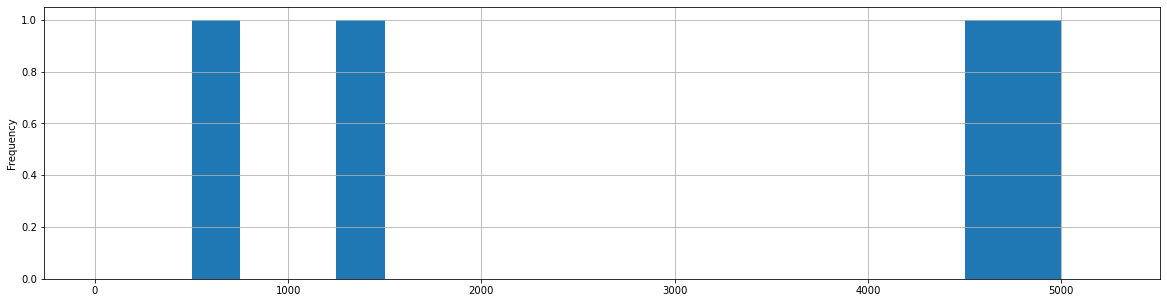

In [28]:
df['unique_lemmas'].plot(kind='hist', grid = True, figsize=(20,5), bins=range(0, 5500, 250))

## Returning the annotated texts as TLPs

Every TLP has a space in front of it and behind it so that a TLP can be defined as 'the characters between two spaces'. This is easier for the (regular expressions in the) next function. The pos tag and lemma are split by '$'.

In [29]:
def get_TLP(text):
    
    new = []
    result = []
    text = text.split(" ")

    for item in text:
        if '\n' in item:
            item = item.splitlines(keepends=True) # keep the new line characters: they indicate rhyme words
            for it in item:
                new.append(it)
        else:
            new.append(item)
            
    for tlp in new:
        if "\n" in tlp:
            tlp = tlp.replace("\n", "/") # turn the new line characters into "/", this is easier to handle
            TLP = re.findall(r"\@(.*?\/)", tlp)
            result.append(TLP[0])

        else:
            TLP = re.findall(r"\@(.*?)(?!\S)", tlp) # keep the other TLPs as they are
            result.append(TLP[0])
            
    # this part of the function helps us handle TLPs as the following: vanden@van+de$adp()+art(def)
    # it splits a contracted form into two (or three) TLPs: van$adp() de$art(def)

    split = []
    for contraction in result:
        if contraction.count("+") == 2:
            contraction = contraction.replace('$', '+')
            contraction = contraction.split("+")
            contraction = contraction[0] + "$" + contraction[2] + " " +  contraction[1] + "$" + contraction[3]
            split.append(contraction)
        elif contraction.count("+") == 1:
            contraction = contraction.replace('$', '+')
            contraction = contraction.split("+")
            contraction = contraction[0] + "$" + contraction[1] + " " +  contraction[0] + "$" + contraction[2]
            split.append(contraction)
        else:
            split.append(contraction)
            
    return " ".join(split)

In [30]:
test =  "vonden@vinden$v(participle,past)\nvan@van$adp() der@de$art(def) scoonre@schoon$adj() vrouwen@vrouw$n(sing) der@de$art(def) blonden@blond$n(sing)\nfraie@fraai$n(sing) rime@rijm$n(plu) ende@en$conj(coord) dat@dat$art(def)+iet(gjv)\nombonden@ontbinden$n(sing)\ndattie@dat+de$conj(subord)+art(def) boeke@boek$n(sing) een@een$art(indef) deel@deel$n(sing) orconden@oorkonden$v(fin,pres,lex)\nniemen@niemand$pron(indef) en@en$adv(neg) mocht@mogen$v(fin,past,aux_cop) al@al$num(indef) ghegronden@gegronden$v(infin)\nnu@nu$adv(dem) quijt@kwijt$adj() ons@ons$pron(poss) vrouwe@vrouw$n(sing) vanden@van+de$adp()+art(def) honden@hond$n(plu)\ndat@dat$conj(subord)"
test = get_TLP(test)
test

'vinden$v(participle,past)/ van$adp() de$art(def) schoon$adj() vrouw$n(sing) de$art(def) blond$n(sing)/ fraai$n(sing) rijm$n(plu) en$conj(coord) dat$art(def) dat$iet(gjv)/ ontbinden$n(sing)/ dat$conj(subord) de$art(def) boek$n(sing) een$art(indef) deel$n(sing) oorkonden$v(fin,pres,lex)/ niemand$pron(indef) en$adv(neg) mogen$v(fin,past,aux_cop) al$num(indef) gegronden$v(infin)/ nu$adv(dem) kwijt$adj() ons$pron(poss) vrouw$n(sing) van$adp() de$art(def) hond$n(plu)/ dat$conj(subord)'

## Segmentation 

We create the (optional) function that substitues all proper names with "X".

In [31]:
def get_no_proper_names (document_list):
    no_proper_names_list = []
    for item in document_list:
        item = re.sub("[a-z]*\$n\(prop\)", "X", item)
        no_proper_names_list.append(item)
    return no_proper_names_list

We create a function to load the directory with the annotated files and return the files in equal segments, based on tag-lemma pairs.

In [32]:
def load_directory(directory, max_length, no_proper_names=False):
    documents, authors, titles, file_names = [], [], [], []
    no_proper_names_list = []
    directory = Path(directory)
    for filename in tqdm(sorted(directory.iterdir())):
        if not filename.suffix == '.txt':
            continue
        title = filename.stem.split("-")[0] # retrieve the title from the file name
        author = filename.stem.split("-")[-2] # retrieve the author from the file name
        file_name = filename.stem

        with filename.open(encoding="utf-8") as f:
            contents = f.read()
            contents = re.sub(r"\n+", "\n", contents) # remove emtpy lines, otherwise get_TLP does not work
        TLP = get_TLP(contents) # turn the contents of the annotated files into TLPs
        start_idx, end_idx, segm_cnt = 0, max_length, 1
        
        tokens = re.findall(r"(?<!\S)(.*?)(?!\S)", TLP) # create a list of TLPs (?<=\s)(.*?)(?=\s)
        
        # extract slices from the text:
        while end_idx < len(tokens):
            documents.append(" ".join(tokens[start_idx:end_idx])) # append slices of the TLP list to another list, as long as their index is lower than the desired segment length
            authors.append(author) # append the authors to the previously defined empty list
            titles.append(f"{title}-{segm_cnt}") # append the titles + segment count to the previously defined empty list
            file_names.append(file_name)
            
            start_idx += max_length
            end_idx += max_length
            segm_cnt += 1
            
    if no_proper_names == True:
        return get_no_proper_names(documents), authors, titles, file_names
    
    else:
        return documents, authors, titles, file_names

All the preprocessing steps have been done now. The only thing left to do, is creating (sorting) the calibration corpora, based on our previously created documents, in order to calibrate our models and apply them to Hendrik van Brussel's possible oeuvre.

## Calibration for "ridderepiek" (chivalric romance)

Loading in the calibration corpus:

In [33]:
documents, authors, titles, file_names = load_directory('ridderepiek', 1698, no_proper_names=True)
authors, titles, file_names

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


(['jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_maerlant',
  'jacob_van_mae

In [34]:
titles[38]

'alexanders_geesten-39'

In [35]:
documents[38]

"de$art(def) koning$n(sing) van$adp() deze$art(def) schare$n(sing)/ hij$pron(pers,3,sing) peinzen$v(fin,past,lex) daarom$pronadv(dem) al$adv(gener)/ dat$conj(subord) het$pron(pers,3,sing) zijn$v(fin,past,aux_cop) zijn$pron(poss) geval$n(sing)/ en$conj(coord) hij$pron(pers,3,sing) varen$v(fin,past,lex) voren$adv(gener) einden$conj(coord) ander$adj() heer$n(sing)/ volgen$v(fin,past,lex) hij$pron(refl,3,sing) niet$adv(neg) groot$adj() geer$n(sing)/ eerst$num(ord) het$art(def) dat$conj(subord) zij$pron(pers,3,plu) komen$v(fin,past,lex) aan$adp() ander$num(ord) de$art(def) land$n(sing)/ slaan$v(fin,past,lex) zij$pron(pers,3,plu) de$art(def) paard$n(plu) al$adv(gener) te$adp() hand$n(sing)/ en$conj(coord) X hij$pron(pers,3,sing) voor$v(fin,past,lex) voren$adv(gener)/ hij$pron(pers,3,sing) volgen$v(fin,past,lex) ridder$n(sing) uitverkoren$v(participle,past)/ ptoleme's1X en$conj(coord) X/ X en$conj(coord) X/ X X en$conj(coord) X/ X en$conj(coord) X/ peussen$n(sing) en$conj(coord) meligaar$n(si

Loading some more libraries:

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from scipy import spatial
import matplotlib.pyplot as plt

Creating a data frame with all of the information regarding the text segments:

In [37]:
dev = {'title': titles, 'author': authors, 'file': file_names, 'segments': documents}
dev = pd.DataFrame(data=dev)
dev

title              author  \
0    alexanders_geesten-1  jacob_van_maerlant   
1    alexanders_geesten-2  jacob_van_maerlant   
2    alexanders_geesten-3  jacob_van_maerlant   
3    alexanders_geesten-4  jacob_van_maerlant   
4    alexanders_geesten-5  jacob_van_maerlant   
..                    ...                 ...   
342     roman_van_torec-9  jacob_van_maerlant   
343    roman_van_torec-10  jacob_van_maerlant   
344    roman_van_torec-11  jacob_van_maerlant   
345    roman_van_torec-12  jacob_van_maerlant   
346    roman_van_torec-13  jacob_van_maerlant   

                                          file  \
0    alexanders_geesten-jacob_van_maerlant-pie   
1    alexanders_geesten-jacob_van_maerlant-pie   
2    alexanders_geesten-jacob_van_maerlant-pie   
3    alexanders_geesten-jacob_van_maerlant-pie   
4    alexanders_geesten-jacob_van_maerlant-pie   
..                                         ...   
342     roman_van_torec-jacob_van_maerlant-pie   
343     roman_van_torec-jacob_van_maerlant-pie   
344     roman_van_torec-jacob_van_maerlant-pie   
345     roman_van_torec-jacob_van_maerlant-pie   
346     roman_van_torec-jacob_van_maerlant-pie   

                                              segments  
0    het$pron(pers,3,sing) zijn$v(fin,pres,aux_cop)...  
1    wat$pron(rel) al$adv(gener) waar$adv(inter) zi...  
2    en$conj(coord) wezen$v(imp) het$art(def) in$ad...  
3    tijd$n(sing)/ goed$adj() oorlogen$v(infin) jeg...  
4    hij$pron(pers,3,sing) de$adp() te$art(def) zel...  
..                                                 ...  
342  en$conj(coord) hebben$v(fin,pres,aux_cop) hij$...  
343  zijn$v(fin,pres,aux_cop) goed$adj() in$adp() a...  
344  die$pron(dem) doen$v(fin,past,aux_cop) hij$pro...  
345  stond$n(sing)/ de$art(def) ridder$n(sing) en$c...  
346  gaan$v(fin,past,lex) weg$v(fin,past,lex) deze$...  

[347 rows x 4 columns]

Obtaining the amount of segments for each text:

In [38]:
for file in dev['file'].unique():
    print(file)
    print(len(dev[dev["file"] == file]))

alexanders_geesten-jacob_van_maerlant-pie
46
floris_ende_blancefloer-dierderic_van_assenede-pie
15
historie_van_den_grale_en_merlijns_boec-jacob_van_maerlant-pie
36
historie_van_troyen-jacob_van_maerlant-pie
139
merlijn-continuatie-lodewijk_van_velthem-pie
98
roman_van_torec-jacob_van_maerlant-pie
13


Features for the vectorizer:

In [39]:
rhyme_words = {'use_idf': False,
          'max_features': 100,
          'analyzer': 'word',
          'token_pattern': r"\w+(?=\$\w+\(\w*\,*\w*\,*\w*\)\/)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

In [40]:
rhyme_vectorizer = TfidfVectorizer(**rhyme_words)

Other features that were tried out (also with different values) for every corpus are the following:

```Python
pos_word = {'use_idf': False,
          'max_features': 6,
          'analyzer': 'word',
          'token_pattern': r"\$(\w*(?=\())",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

pos_word_all = {'use_idf': False,
          'max_features':2000,
          'analyzer': 'word',
          'token_pattern': r"(?<=\$)(.*?\))",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

lemma_word_tfidf = {'use_idf': True,
          'max_features':50000,
          'analyzer': 'word',
          'token_pattern': r"\w+(?=\$)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

lemma_word_count = {'use_idf': False,
          'max_features':  1000,
          'analyzer': 'word',
          'token_pattern': r"\w+(?=\$)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

TLP = {'use_idf':False,
          'max_features':1000,
          'analyzer': 'word',
          'token_pattern': r"(?<!\S)(.*?)(?!\S)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

rhyme_words = {'use_idf': True,
          'max_features': 2000,
          'analyzer': 'word',
          'token_pattern': r"\w+(?=\$\w+\(\w*\,*\w*\,*\w*\)\/)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}


rhyme_words_all = {'use_idf': False,
          'max_features':100,
          'analyzer': 'word',
          'token_pattern': r"([^ ]*)\/",
#           'min_df': 2,
          'norm': 'l1', 
          'ngram_range': (1, 1)}

function_words_all = {'use_idf': False,
          'max_features': 1000,
          'analyzer': 'word',
          'token_pattern': r"[a-z]*\$[apc][rdo][topn][nj]*\(.*?\)", # articles, pronouns, adpositions, conjunctives
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

function_words = {'use_idf': False,
          'max_features': 300,
          'analyzer': 'word',
          'token_pattern': r"([a-z]*)\$[apc][rdo][topn][nj]*\(.*?\)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}
          
```

Fitting and tranforming:

In [41]:
dev_X = rhyme_vectorizer.fit_transform(dev['segments']).toarray()

The number of segments in the first spot and the amount of features in the second spot:

In [42]:
dev_X.shape

(347, 100)

We define a calibrator class here. It selects all same author (SA) and different author (DA) pairs:
- SA pair: all pairs of segments that are written by the same author but are not from the same text
- DA pair: all pairs of segments that are written by different authors

For every pair, the average cosine distance between the two segments is calculated by n random feature bootstraps.

In [43]:
class Calibrator():
    def __init__(self, iters=200,
                 rnd_prop=.5, random_state=1066,
                 metric='cosine',
                 rnd_state=1234):
        assert (rnd_prop >= 0.0) and (rnd_prop <= 1.0)
        
        np.random.seed(rnd_state)
        self.iters = iters
        self.rnd_prop = rnd_prop
    
    def calculate_distance(self, dev, dev_X):

        total_features = dev_X.shape[1]
        
        mean_total_DA = []
        mean_total_SA = []
        
        clustermap = np.zeros((dev_X.shape[0],  dev_X.shape[0])) # creating an array consisting of zeroes, in order to add the distances of all the iterations later on (that way, a clustermap can be created) 
        
        for it in tqdm(range(self.iters)):
            
            dev_ = dev_X

            if self.rnd_prop < 1.0: #  selecting the random proportion of features (if needed)
                idxs = np.random.choice(total_features, int(total_features * self.rnd_prop), replace=False)
                dev_ = dev_X[:, idxs]

            SA = []
            DA = []
            
            one_iter = np.zeros((dev_X.shape[0],  dev_X.shape[0])) # creating an array consisting of zeroes, in order to add the distances between texts of one iteration

            for idx_first_text,  first_text in dev.iterrows():

                for idx_second_text, second_text in dev.iterrows():

                    if (dev['author'][idx_first_text] == dev['author'][idx_second_text]) and (dev['file'][idx_first_text] != dev['file'][idx_second_text]): # same author (SA) pairs: not the same text, but the same author
                        distance = spatial.distance.cosine(dev_[idx_first_text], dev_[idx_second_text])
                        SA.append(distance)
                        
                        one_iter[idx_first_text, idx_second_text] = distance # add the distance in the right place in the array
                        
                    if (dev['author'][idx_first_text] != dev['author'][idx_second_text]): # different author (DA) pairs: not the same author
                        distance = spatial.distance.cosine(dev_[idx_first_text], dev_[idx_second_text])
                        DA.append(distance)
                        
                        one_iter[idx_first_text, idx_second_text] = distance # add the distance in the right place in the array

            clustermap = np.add(clustermap, one_iter) # add up all the distances of all the iterations

            mean_SA = sum(SA)/len(SA)
            try:
                mean_DA = sum(DA)/len(DA)
            except ZeroDivisionError: # if there are no DA pairs
                mean_DA = 0
            
            mean_total_SA.append(mean_SA)
            mean_total_DA.append(mean_DA)
            
        clustermap = np.divide(clustermap, self.iters) # divide the added up distances with the amount of iterations, in order to get the mean distance of every text pair

        return mean_total_SA, mean_total_DA, clustermap

In [44]:
calibrator = Calibrator(iters=200, rnd_prop=0.5) # 200 iterations based on 50% of the features

In [45]:
result_SA, result_DA, clustermap = calibrator.calculate_distance(dev, dev_X)
result_SA, result_DA 

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [59:45<00:00, 17.93s/it]


([0.4229029611792409,
  0.41007799801290395,
  0.44786304443404656,
  0.4940315750664176,
  0.48594671133488054,
  0.40535145567777775,
  0.41365131247138676,
  0.3820223750460448,
  0.5169771305749103,
  0.43581101271528216,
  0.40664068847560353,
  0.4892381651035153,
  0.4891901633194634,
  0.49244109341067227,
  0.37802373198415445,
  0.3621415600108246,
  0.43587653468157256,
  0.3838189246323457,
  0.44213319146046937,
  0.5015825008928364,
  0.4475561856229794,
  0.4817978982512028,
  0.3991719827644026,
  0.4080043521155683,
  0.38207805974264913,
  0.4822626267866314,
  0.39990840205620765,
  0.4369509948367899,
  0.41628720151054105,
  0.5073060888495706,
  0.5212434417325059,
  0.37725289013321534,
  0.5058651307593925,
  0.4260826573876732,
  0.4356218704427574,
  0.43542835255811946,
  0.3805607130240447,
  0.4119751003973796,
  0.3961566966525867,
  0.44388835259271014,
  0.45506377276579124,
  0.3961924515305107,
  0.5308338895709704,
  0.4000383099308079,
  0.3919382615

The average SA and DA distances:

In [46]:
avg_SA = sum(result_SA)/len(result_SA)
print(round(avg_SA, 4))
avg_DA = sum(result_DA)/len(result_DA)
print(round(avg_DA, 4))

0.4313
0.531


The median SA and DA distances:

In [47]:
import statistics
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.4264928309977989
0.5305613116022481


A boxplot with the distribution of the cosine distances between SA and DA pairs:

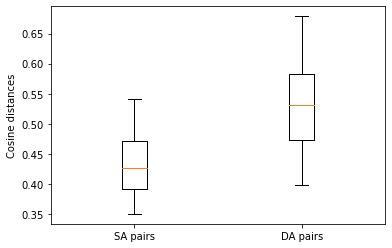

In [48]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, result_DA])
ax.set(xticklabels=('SA pairs', 'DA pairs'), ylabel='Cosine distances');

Creating a clustermap of the works and their distances (https://seaborn.pydata.org/generated/seaborn.clustermap.html):

In [49]:
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as hierarchy
import seaborn
import collections

In [50]:
cluster_frame = pd.DataFrame(data=clustermap)
cluster_frame = cluster_frame.set_index(dev['file'])
cluster_frame.set_axis(dev["file"].values.tolist(), axis=1, inplace=True)
cluster_frame

alexanders_geesten-jacob_van_maerlant-pie  \
file                                                                                   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
...                                                                              ...   
roman_van_torec-jacob_van_maerlant-pie                                      0.469211   
roman_van_torec-jacob_van_maerlant-pie                                      0.428786   
roman_van_torec-jacob_van_maerlant-pie                                      0.531876   
roman_van_torec-jacob_van_maerlant-pie                                      0.387474   
roman_van_torec-jacob_van_maerlant-pie                                      0.515776   

                                           alexanders_geesten-jacob_van_maerlant-pie  \
file                                                                                   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
...                                                                              ...   
roman_van_torec-jacob_van_maerlant-pie                                      0.422852   
roman_van_torec-jacob_van_maerlant-pie                                      0.492608   
roman_van_torec-jacob_van_maerlant-pie                                      0.481174   
roman_van_torec-jacob_van_maerlant-pie                                      0.404714   
roman_van_torec-jacob_van_maerlant-pie                                      0.488836   

                                           alexanders_geesten-jacob_van_maerlant-pie  \
file                                                                                   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
...                                                                              ...   
roman_van_torec-jacob_van_maerlant-pie                                      0.572741   
roman_van_torec-jacob_van_maerlant-pie                                      0.521689   
roman_van_torec-jacob_van_maerlant-pie                                      0.588186   
roman_van_torec-jacob_van_maerlant-pie                                      0.474849   
roman_van_torec-jacob_van_maerlant-pie                                      0.553937   

                                           alexanders_geesten-jacob_van_maerlant-pie  \
file                                                                                   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.000000   
alexanders_geesten-jacob_van_maerlant-pie                                   0.00

In [51]:
def get_cluster_per_text (cluster_frame):
    
    new = cluster_frame.groupby(cluster_frame.columns, axis=1).sum() 
    new = new.groupby(cluster_frame.columns, axis=0).sum()
    
    segments = collections.Counter(cluster_frame.columns)
    
    for index, i in new.iterrows():
        for c in segments.keys():
            i[c] = i[c] / (int(segments.get(c)) * int(segments.get(index)))
                
    return new
        

In [52]:
get_cluster_per_text (cluster_frame)

alexanders_geesten-jacob_van_maerlant-pie  \
alexanders_geesten-jacob_van_maerlant-pie                                            0.000000   
floris_ende_blancefloer-dierderic_van_assenede-pie                                   0.465039   
historie_van_den_grale_en_merlijns_boec-jacob_v...                                   0.428216   
historie_van_troyen-jacob_van_maerlant-pie                                           0.413052   
merlijn-continuatie-lodewijk_van_velthem-pie                                         0.551395   
roman_van_torec-jacob_van_maerlant-pie                                               0.482879   

                                                    floris_ende_blancefloer-dierderic_van_assenede-pie  \
alexanders_geesten-jacob_van_maerlant-pie                                                    0.465039    
floris_ende_blancefloer-dierderic_van_assenede-pie                                           0.000000    
historie_van_den_grale_en_merlijns_boec-jacob_v...                                           0.457389    
historie_van_troyen-jacob_van_maerlant-pie                                                   0.468065    
merlijn-continuatie-lodewijk_van_velthem-pie                                                 0.603587    
roman_van_torec-jacob_van_maerlant-pie                                                       0.520926    

                                                    historie_van_den_grale_en_merlijns_boec-jacob_van_maerlant-pie  \
alexanders_geesten-jacob_van_maerlant-pie                                                    0.428216                
floris_ende_blancefloer-dierderic_van_assenede-pie                                           0.457389                
historie_van_den_grale_en_merlijns_boec-jacob_v...                                           0.000000                
historie_van_troyen-jacob_van_maerlant-pie                                                   0.431893                
merlijn-continuatie-lodewijk_van_velthem-pie                                                 0.529424                
roman_van_torec-jacob_van_maerlant-pie                                                       0.451545                

                                                    historie_van_troyen-jacob_van_maerlant-pie  \
alexanders_geesten-jacob_van_maerlant-pie                                             0.413052   
floris_ende_blancefloer-dierderic_van_assenede-pie                                    0.468065   
historie_van_den_grale_en_merlijns_boec-jacob_v...                                    0.431893   
historie_van_troyen-jacob_van_maerlant-pie                                            0.000000   
merlijn-continuatie-lodewijk_van_velthem-pie                                          0.552916   
roman_van_torec-jacob_van_maerlant-pie                                                0.474602   

                                                    merlijn-continuatie-lodewijk_van_velthem-pie  \
alexanders_geesten-jacob_van_maerlant-pie                                               0.551395   
floris_ende_blancefloer-dierderic_van_assenede-pie                                      0.603587   
historie_van_den_grale_en_merlijns_boec-jacob_v...                                      0.529424   
historie_van_troyen-jacob_van_maerlant-pie                                              0.552916   
merlijn-continuatie-lodewijk_van_velthem-pie                                            0.000000   
roman_van_torec-jacob_van_maerlant-pie                                                  0.315493   

                                                    roman_van_torec-jacob_van_maerlant-pie  
alexanders_geesten-jacob_van_maerlant-pie                                         0.482879  
floris_ende_blancefloer-dierderic_van_assenede-pie                                0.520926  
historie_van_den_grale_en_merlijns_boec-jacob_v...                                0.451545  
historie_van_troyen-jacob_van_maerlant-pie

C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


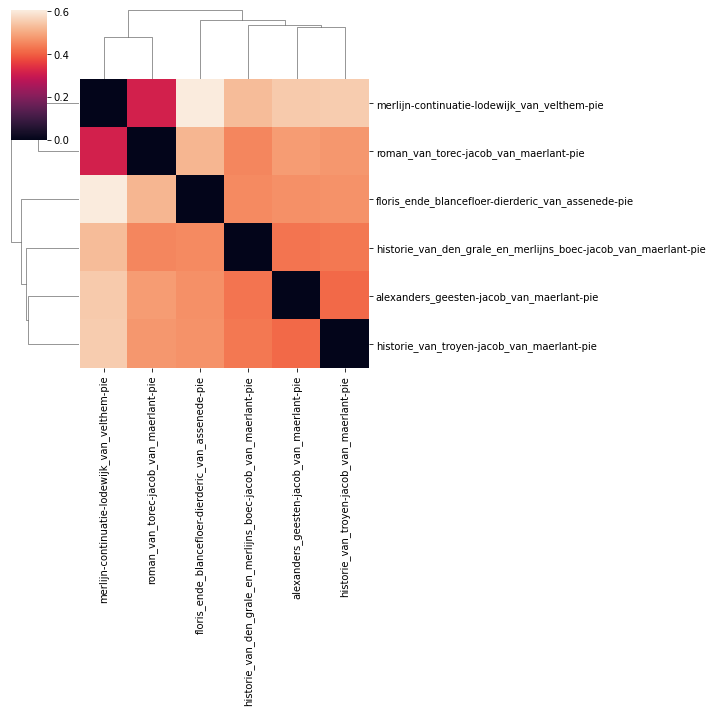

In [53]:
seaborn.clustermap(get_cluster_per_text (cluster_frame), figsize=(10,10))

In [54]:
# cluster_frame.to_csv('clustermap.csv', encoding='utf-8')

Obtaining some extra statistics (we can only do this now because of the preprocessing):

In [55]:
def get_unique_rhyme (text):
    rhyme = re.findall("\w+(?=\$\w+\(\w*\,*\w*\,*\w*\)\/)", text)
    rhyme = set(rhyme) # get the unique items of the previously obtained list
    return list(rhyme)

def number_unique_rhyme (text):
    text = set(text)
    return len(text)

def get_verse (text):
    verses = text.count("/")
    return verses

In [56]:
dev["unique_rhyme"] = dev['segments'].apply(get_unique_rhyme)
stat = dev.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

title  \
file                                                                                                    
alexanders_geesten-jacob_van_maerlant-pie           alexanders_geesten-1alexanders_geesten-2alexan...   
floris_ende_blancefloer-dierderic_van_assenede-pie  floris_ende_blancefloer-1floris_ende_blanceflo...   
historie_van_den_grale_en_merlijns_boec-jacob_v...  historie_van_den_grale_en_merlijns_boec-1histo...   
historie_van_troyen-jacob_van_maerlant-pie          historie_van_troyen-1historie_van_troyen-2hist...   
merlijn-continuatie-lodewijk_van_velthem-pie        merlijn-1merlijn-2merlijn-3merlijn-4merlijn-5m...   
roman_van_torec-jacob_van_maerlant-pie              roman_van_torec-1roman_van_torec-2roman_van_to...   

                                                                                               author  \
file                                                                                                    
alexanders_geesten-jacob_van_maerlant-pie           jacob_van_maerlantjacob_van_maerlantjacob_van_...   
floris_ende_blancefloer-dierderic_van_assenede-pie  dierderic_van_assenededierderic_van_assenededi...   
historie_van_den_grale_en_merlijns_boec-jacob_v...  jacob_van_maerlantjacob_van_maerlantjacob_van_...   
historie_van_troyen-jacob_van_maerlant-pie          jacob_van_maerlantjacob_van_maerlantjacob_van_...   
merlijn-continuatie-lodewijk_van_velthem-pie        lodewijk_van_velthemlodewijk_van_velthemlodewi...   
roman_van_torec-jacob_van_maerlant-pie              jacob_van_maerlantjacob_van_maerlantjacob_van_...   

                                                                                             segments  \
file                                                                                                    
alexanders_geesten-jacob_van_maerlant-pie           het$pron(pers,3,sing) zijn$v(fin,pres,aux_cop)...   
floris_ende_blancefloer-dierderic_van_assenede-pie  nu$adv(dem) horen$v(imp) na$adp() ik$pron(pers...   
historie_van_den_grale_en_merlijns_boec-jacob_v...  al$num(indef) de$art(def) geen$pron(dem) die$p...   
historie_van_troyen-jacob_van_maerlant-pie          deus$n(sing) achtste$misc()/ mijn$pron(poss) h...   
merlijn-continuatie-lodewijk_van_velthem-pie        god$n(sing) die$pron(rel) al$num(indef) ding$n...   
roman_van_torec-jacob_van_maerlant-pie              de$art(def) avontuur$n(sing) doen$v(fin,pres,l...   

                                                                                         unique_rhyme  \
file                                                                                                    
alexanders_geesten-jacob_van_maerlant-pie           [wind, voren, minne, hoofd, verdoofd, gestade,...   
floris_ende_blancefloer-dierderic_van_assenede-pie  [wind, voren, zand, minne, zee, kond, dier, we...   
historie_van_den_grale_en_merlijns_boec-jacob_v...  [voren, graal, verdienen, hoofd, deze, gedicht...   
historie_van_troyen-jacob_van_maerlant-pie          [opnemen, voren, hoofd, deze, geloven, tijns, ...   
merlijn-continuatie-lodewijk_van_velthem-pie        [voren, angstand, wet, verstaan, uitgeven, sin...   
roman_van_torec-jacob_van_maerlant-pie              [deze, kond, verstaan, bezweren, lof, daarnaar...   

                                                    unique_rhyme_amount  
file                                                                     
alexanders_geesten-jacob_van_maerlant-pie                          1885  
floris_ende_blancefloer-dierderic_van_assenede-pie                  915  
historie_van_den_grale_en_merlijns_boec-jacob_v...                 1381  
historie_van_troyen-jacob_van_maerlant-pie                         3250  
merlijn-continuatie-lodewijk_van_velthem-pie                       1605  
roman_van_torec-jacob_van_maerlant-pie                              794

In [57]:
dev["rhyme"] = dev['segments'].apply(get_verse)
stat = dev.groupby('file').agg(sum)
stat

rhyme
file                                                     
alexanders_geesten-jacob_van_maerlant-pie           14108
floris_ende_blancefloer-dierderic_van_assenede-pie   3764
historie_van_den_grale_en_merlijns_boec-jacob_v...  10025
historie_van_troyen-jacob_van_maerlant-pie          40596
merlijn-continuatie-lodewijk_van_velthem-pie        25668
roman_van_torec-jacob_van_maerlant-pie               3575

## Verification (based on the previous model)

Applying the verification to the possible oeuvre of Hendrik van Brussel:

In [58]:
test_directory = 'hendrik'

test_documents, test_authors, test_titles, test_file_names = load_directory(test_directory, 1698, no_proper_names=True)
test_documents, test_authors, test_titles, test_file_names

test = {'title': test_titles, 'author': test_authors, 'file': test_file_names, 'segments': test_documents}
test = pd.DataFrame(data=test)
test

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44it/s]


title               author  \
0    (korte)_roman_van_cassamus-1  hendrik_van_brussel   
1    (korte)_roman_van_cassamus-2  hendrik_van_brussel   
2    (korte)_roman_van_cassamus-3  hendrik_van_brussel   
3    (korte)_roman_van_cassamus-4  hendrik_van_brussel   
4    (korte)_roman_van_cassamus-5  hendrik_van_brussel   
..                            ...                  ...   
125         roman_van_limborch-69  hendrik_van_brussel   
126         roman_van_limborch-70  hendrik_van_brussel   
127         roman_van_limborch-71  hendrik_van_brussel   
128         roman_van_limborch-72  hendrik_van_brussel   
129         roman_van_limborch-73  hendrik_van_brussel   

                                                  file  \
0    (korte)_roman_van_cassamus-hendrik_van_brussel...   
1    (korte)_roman_van_cassamus-hendrik_van_brussel...   
2    (korte)_roman_van_cassamus-hendrik_van_brussel...   
3    (korte)_roman_van_cassamus-hendrik_van_brussel...   
4    (korte)_roman_van_cassamus-hendrik_van_brussel...   
..                                                 ...   
125         roman_van_limborch-hendrik_van_brussel-pie   
126         roman_van_limborch-hendrik_van_brussel-pie   
127         roman_van_limborch-hendrik_van_brussel-pie   
128         roman_van_limborch-hendrik_van_brussel-pie   
129         roman_van_limborch-hendrik_van_brussel-pie   

                                              segments  
0    X/ na$adp() die$pron(dem) dat$conj(subord) de$...  
1    op$adp() een$art(indef) rivier$n(sing)/ en$con...  
2    negeen$pron(indef) ontzeggen$v(fin,past,lex)/ ...  
3    te+wij+waart$adp()+pron(pers,1,plu)+adp() kome...  
4    kracht$n(sing) daar$pronadv(dem) mede$pronadv(...  
..                                                 ...  
125  ik$pron(pers,1,sing) mogen$v(fin,pres,aux_cop)...  
126  de$art(def) weg$n(sing) iet$pron(indef) togen$...  
127  groot$adj() plein$n(sing) zij$pron(pers,3,plu)...  
128  komen$v(participle,pres) verzien$v(infin)/ en$...  
129  komen$v(fin,pres,lex) van$adp() de$moe X de$ar...  

[130 rows x 4 columns]

Obtaining the amount of segments for each text:

In [59]:
for file in test['file'].unique():
    print(file)
    print(len(test[test["file"] == file]))

(korte)_roman_van_cassamus-hendrik_van_brussel-pie
6
die_rose-hendrik_van_brussel-pie
50
hughen_van_tabaryen-hendrik_van_brussel-pie
1
roman_van_limborch-hendrik_van_brussel-pie
73


In [60]:
test_X = rhyme_vectorizer.transform(test['segments']).toarray() # use the fitted vectorizer

test_result_SA, test_result_DA, test_clustermap = calibrator.calculate_distance(test, test_X) # use the calibrator defined previously
test_result_SA, test_result_DA

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:44<00:00,  2.32s/it]


([0.33140329002845376,
  0.3210957443171834,
  0.39391281928227523,
  0.37480680023684493,
  0.4337540230362498,
  0.40649415509031533,
  0.33750981231358884,
  0.4504988446116207,
  0.47237178735306073,
  0.45902884812429284,
  0.3918709602267381,
  0.32051868248026816,
  0.37605110189462443,
  0.3582426138078829,
  0.31250597221400706,
  0.3189242515680929,
  0.4699548400973923,
  0.4535313214824039,
  0.3737381586044102,
  0.32300366492243066,
  0.3723646136199621,
  0.37862123813190657,
  0.387919167462171,
  0.37356517226582797,
  0.3550943813962653,
  0.37837818985130234,
  0.4236336532633821,
  0.3889982332752915,
  0.3759457587159804,
  0.3238007381783262,
  0.32845155317713126,
  0.3828944091662325,
  0.35518981780538256,
  0.43059892653142,
  0.4046061472685658,
  0.4611664030972294,
  0.32619226359454073,
  0.35450889441096173,
  0.35115063621133985,
  0.36337028299435586,
  0.36501568333141704,
  0.37307469786840597,
  0.47678179589441644,
  0.36805384054682855,
  0.4242684

The average distances (we want to examine whether the works were written by the same author, so we only calculate one value now. Do not mind the names of the variables):

In [61]:
test_avg_SA = sum(test_result_SA)/len(test_result_SA)
print(round(test_avg_SA, 4))
test_avg_DA = sum(test_result_DA)/len(test_result_DA)
print(round(test_avg_DA, 4))

0.3774
0.0


The median distances:

In [62]:
print(statistics.median(test_result_SA))
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.372645239280544
0.4264928309977989
0.5305613116022481


A boxplot with the distribution of the cosine distances:

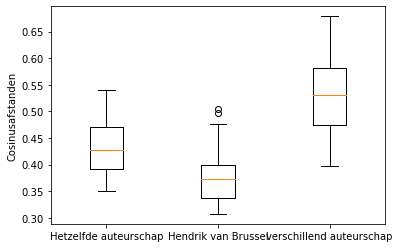

In [63]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, test_result_SA, result_DA])
ax.set(xticklabels=('Hetzelfde auteurschap', 'Hendrik van Brussel', 'verschillend auteurschap'), ylabel='Cosinusafstanden');

Creating a clustermap of the works and their distances. 

In [64]:
test_cluster_frame = pd.DataFrame(data=test_clustermap)
test_cluster_frame = test_cluster_frame.set_index(test['file'])
test_cluster_frame.set_axis(test["file"].values.tolist(), axis=1, inplace=True)
test_cluster_frame

(korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.373375    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.373725    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.380684    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.442884    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.441932    

                                                    (korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.289743    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.261028    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.261667    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.329337    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.376015    

                                                    (korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.380838    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.343984    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.176404    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.363623    
roman_van_limborch-hen

C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


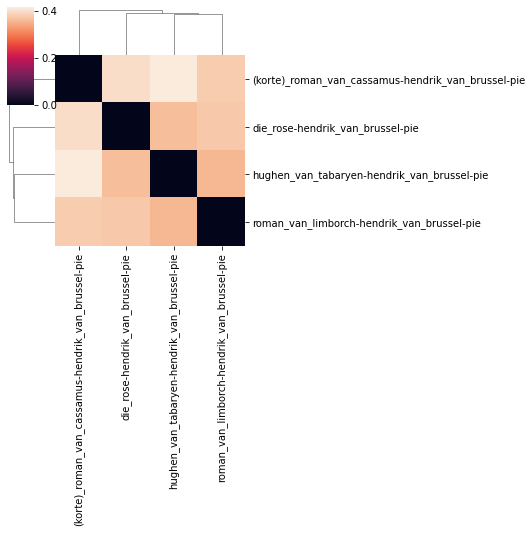

In [65]:
seaborn.clustermap(get_cluster_per_text(test_cluster_frame), figsize=(7.5, 7.5))

Obtaining some extra statistics (we can only do this now because of the preprocessing):

In [66]:
test["unique_rhyme"] = test['segments'].apply(get_unique_rhyme)
stat = test.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

title  \
file                                                                                                    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie  (korte)_roman_van_cassamus-1(korte)_roman_van_...   
die_rose-hendrik_van_brussel-pie                    die_rose-1die_rose-2die_rose-3die_rose-4die_ro...   
hughen_van_tabaryen-hendrik_van_brussel-pie                                     hughen_van_tabaryen-1   
roman_van_limborch-hendrik_van_brussel-pie          roman_van_limborch-1roman_van_limborch-2roman_...   

                                                                                               author  \
file                                                                                                    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie  hendrik_van_brusselhendrik_van_brusselhendrik_...   
die_rose-hendrik_van_brussel-pie                    hendrik_van_brusselhendrik_van_brusselhendrik_...   
hughen_van_tabaryen-hendrik_van_brussel-pie                                       hendrik_van_brussel   
roman_van_limborch-hendrik_van_brussel-pie          hendrik_van_brusselhendrik_van_brusselhendrik_...   

                                                                                             segments  \
file                                                                                                    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie  X/ na$adp() die$pron(dem) dat$conj(subord) de$...   
die_rose-hendrik_van_brussel-pie                    het$pron(pers,3,sing) zeggen$v(fin,pres,lex) m...   
hughen_van_tabaryen-hendrik_van_brussel-pie         het$pron(pers,3,sing) doen$v(fin,pres,aux_cop)...   
roman_van_limborch-hendrik_van_brussel-pie          ootmoedig$adj() god$n(sing) geweldig$adj() hee...   

                                                                                         unique_rhyme  \
file                                                                                                    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie  [voren, emminoda, pond, wijs, jongeling, sprek...   
die_rose-hendrik_van_brussel-pie                    [voren, minne, bekommert, verstaan, ie, naaldj...   
hughen_van_tabaryen-hendrik_van_brussel-pie         [voren, nimmee, deze, wee, verstaan, bezweren,...   
roman_van_limborch-hendrik_van_brussel-pie          [voren, noemen, schoonheid, verblijden, dier, ...   

                                                    unique_rhyme_amount  
file                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                  569  
die_rose-hendrik_van_brussel-pie                                   2085  
hughen_van_tabaryen-hendrik_van_brussel-pie                         198  
roman_van_limborch-hendrik_van_brussel-pie                         2084

In [67]:
test["rhyme"] = test['segments'].apply(get_verse)
stat = test.groupby('file').agg(sum)
stat

rhyme
file                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie   1724
die_rose-hendrik_van_brussel-pie                    14132
hughen_van_tabaryen-hendrik_van_brussel-pie           272
roman_van_limborch-hendrik_van_brussel-pie          21660

## Calibration for "historische kronieken" (chronicles)

Loading in the calibration corpus:

In [68]:
documents, authors, titles, file_names = load_directory('spiegel_historiael', 1698, no_proper_names=True)
authors, titles, file_names

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s]


(['jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van

In [69]:
titles[38]

'brabantsche_yeesten__1-39'

In [70]:
documents[38]

'vallen$v(fin,past,lex) dat$pron(dem) wel$adv(gener) op$adp() haar$pron(poss) hoede$n(sing)/ dat$conj(subord) de$art(def) hertog$n(sing) in$adp() erre$adj() moed$n(sing)/ te$adp() haastelijk$adv(gener) mogen$v(fin,past,aux_cop) recht$v(infin) gaan$v(infin)/ als$conj(comp) hij$pron(pers,3,sing) te$adp() voor$adv(gener) hebben$v(fin,past,aux_cop) doen$v(participle,past)/ antwerpen$n(sing) te$adp() daar$adv(rel) men$pron(indef) lieden$n(plu) nemen$v(fin,past,lex) het$art(def) leven$n(sing)/ dat$pron(dem) beter$adj() zijn$v(fin,past,aux_cop) achter$adv(gener) blijven$v(participle,past)/ en$conj(coord) slot$n(plu) haar$pron(poss) poort$n(plu) te$pronadv(pers)/ jegen$adp() de$art(def) hertog$n(sing) en$conj(coord) de$art(def) zijn$pron(poss) toen$adv(dem)/ de$art(def) hertog$n(sing) worden$v(fin,past,aux_cop) gram$adj() hier$pronadv(dem) om$pronadv(prep)/ en$conj(coord) beliggen$v(fin,past,lex) de$art(def) stad$n(sing) al$adv(gener) om$adp()/ en$conj(coord) steken$v(fin,past,lex) in$adp() de

Creating a data frame with all of the information regarding the text segments:

In [71]:
dev = {'title': titles, 'author': authors, 'file': file_names, 'segments': documents}
dev = pd.DataFrame(data=dev)
dev

title                author  \
0    brabantsche_yeesten__1-1      jan_van_boendale   
1    brabantsche_yeesten__1-2      jan_van_boendale   
2    brabantsche_yeesten__1-3      jan_van_boendale   
3    brabantsche_yeesten__1-4      jan_van_boendale   
4    brabantsche_yeesten__1-5      jan_van_boendale   
..                        ...                   ...   
622  spiegel_historiael__5-62  lodewijk_van_velthem   
623  spiegel_historiael__5-63  lodewijk_van_velthem   
624  spiegel_historiael__5-64  lodewijk_van_velthem   
625  spiegel_historiael__5-65  lodewijk_van_velthem   
626  spiegel_historiael__5-66  lodewijk_van_velthem   

                                               file  \
0     brabantsche_yeesten__1-5-jan_van_boendale-pie   
1     brabantsche_yeesten__1-5-jan_van_boendale-pie   
2     brabantsche_yeesten__1-5-jan_van_boendale-pie   
3     brabantsche_yeesten__1-5-jan_van_boendale-pie   
4     brabantsche_yeesten__1-5-jan_van_boendale-pie   
..                                              ...   
622  spiegel_historiael__5-lodewijk_van_velthem-pie   
623  spiegel_historiael__5-lodewijk_van_velthem-pie   
624  spiegel_historiael__5-lodewijk_van_velthem-pie   
625  spiegel_historiael__5-lodewijk_van_velthem-pie   
626  spiegel_historiael__5-lodewijk_van_velthem-pie   

                                              segments  
0    om$adp() dat$pron(dem) van$adp() X de$art(def)...  
1    in$adp() de$art(def) woud$n(sing)/ kluizenaar$...  
2    mede$adv(gener) ander$adj() lieden$n(plu)/ de$...  
3    hij$pron(pers,3,sing) in$adp() de$art(def) eer...  
4    zijn$v(fin,past,aux_cop) worden$v(participle,p...  
..                                                 ...  
622  om$adp() hij$pron(pers,3,sing) daar$adv(dem) t...  
623  doen$conj(subord) zij$pron(pers,3,plu) en$conj...  
624  zo$adv(resum) van$adp() al$num(indef) ander$ad...  
625  ik$pron(pers,1,sing) zoeken$v(fin,past,lex) uw...  
626  maken$v(fin,past,lex) te$art(def) de$adp() sta...  

[627 rows x 4 columns]

Obtaining the amount of segments:

In [72]:
for file in dev['file'].unique():
    print(file)
    print(len(dev[dev["file"] == file]))

brabantsche_yeesten__1-5-jan_van_boendale-pie
53
der_leken_spieghel-jan_van_boendale-pie
71
spiegel_historiael__1-jacob_van_maerlant-pie
106
spiegel_historiael__2-philip_utenbroeke-pie
117
spiegel_historiael__3_4-jacob_van_maerlant-pie
191
spiegel_historiael__4-lodewijk_van_velthem-pie 
23
spiegel_historiael__5-lodewijk_van_velthem-pie
66


Features for the vectorizer:

In [73]:
rhyme_words = {'use_idf': True,
          'max_features': 100,
          'analyzer': 'word',
          'token_pattern': r"\w+(?=\$\w+\(\w*\,*\w*\,*\w*\)\/)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

In [74]:
rhyme_vectorizer = TfidfVectorizer(**rhyme_words)

Fitting and tranforming:

In [75]:
dev_X = rhyme_vectorizer.fit_transform(dev['segments']).toarray()

The number of segments in the first spot and the amount of features in the second spot:

In [76]:
dev_X.shape

(627, 100)

Using the "Calibrator":

In [77]:
calibrator = Calibrator(iters=200, rnd_prop=0.5) # 200 iterations based on 50% of the features

In [78]:
result_SA, result_DA, clustermap = calibrator.calculate_distance(dev, dev_X)
result_SA, result_DA 

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [3:06:08<00:00, 55.84s/it]


([0.3944279402889042,
  0.3933877171513391,
  0.3960938498963952,
  0.42010838256307914,
  0.38330847502701765,
  0.4369588143419768,
  0.38842290960149345,
  0.4148423842056852,
  0.5140593563358762,
  0.39353787434074905,
  0.420646656666018,
  0.42516268129304363,
  0.4874711634171582,
  0.4846423922102706,
  0.4244982499754944,
  0.43033328327268927,
  0.4207114427148077,
  0.4150524999894643,
  0.4029449715282014,
  0.4706560468330701,
  0.4739636834703964,
  0.4503274483211488,
  0.47679820114879035,
  0.47516132616358625,
  0.4102530408260765,
  0.380842917679132,
  0.4731562754531294,
  0.48864900045381027,
  0.45007092327784765,
  0.4008362092660867,
  0.4125667166501433,
  0.4868297634602733,
  0.37755180506187674,
  0.440154520334872,
  0.4130118958739349,
  0.45347171721168134,
  0.4607746935802404,
  0.3940959605165671,
  0.4152030530235193,
  0.463576321087379,
  0.4109717994873893,
  0.4444055119053339,
  0.38275099305332483,
  0.4117676477808852,
  0.42192147085171156,


The average SA and DA distances:

In [79]:
avg_SA = sum(result_SA)/len(result_SA)
print(round(avg_SA, 4))
avg_DA = sum(result_DA)/len(result_DA)
print(round(avg_DA, 4))

0.4352
0.455


The median SA and DA distances:

In [80]:
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.4289093933952588
0.44570773677566733


A boxplot with the distribution of the cosine distances between SA and DA pairs:

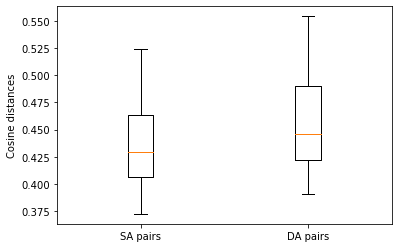

In [81]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, result_DA])
ax.set(xticklabels=('SA pairs', 'DA pairs'), ylabel='Cosine distances');

Creating a clustermap of the works and their distances:

In [82]:
cluster_frame = pd.DataFrame(data=clustermap)
cluster_frame = cluster_frame.set_index(dev['file'])
cluster_frame.set_axis(dev["file"].values.tolist(), axis=1, inplace=True)
cluster_frame

brabantsche_yeesten__1-5-jan_van_boendale-pie  \
file                                                                                            
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
...                                                                                       ...   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.422145   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.460868   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.424299   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.447864   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.357112   

                                                brabantsche_yeesten__1-5-jan_van_boendale-pie  \
file                                                                                            
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
...                                                                                       ...   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.474251   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.542253   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.538622   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.543457   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.464761   

                                                brabantsche_yeesten__1-5-jan_van_boendale-pie  \
file                                                                                            
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.000000   
...                                                                                       ...   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.534466   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.564339   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.550996   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.541881   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.520421   

                                                brabantsche_yeesten__1-5-jan_van_boendale-pie  \
file                                                                                            
brabantsche_yeesten__1-5-jan_van_boendale-pie                       

In [83]:
get_cluster_per_text (cluster_frame)

brabantsche_yeesten__1-5-jan_van_boendale-pie  \
brabantsche_yeesten__1-5-jan_van_boendale-pie                                         0.000000   
der_leken_spieghel-jan_van_boendale-pie                                               0.450915   
spiegel_historiael__1-jacob_van_maerlant-pie                                          0.431200   
spiegel_historiael__2-philip_utenbroeke-pie                                           0.441493   
spiegel_historiael__3_4-jacob_van_maerlant-pie                                        0.415294   
spiegel_historiael__4-lodewijk_van_velthem-pie                                        0.457557   
spiegel_historiael__5-lodewijk_van_velthem-pie                                        0.462338   

                                                 der_leken_spieghel-jan_van_boendale-pie  \
brabantsche_yeesten__1-5-jan_van_boendale-pie                                   0.450915   
der_leken_spieghel-jan_van_boendale-pie                                         0.000000   
spiegel_historiael__1-jacob_van_maerlant-pie                                    0.460356   
spiegel_historiael__2-philip_utenbroeke-pie                                     0.430082   
spiegel_historiael__3_4-jacob_van_maerlant-pie                                  0.474754   
spiegel_historiael__4-lodewijk_van_velthem-pie                                  0.458045   
spiegel_historiael__5-lodewijk_van_velthem-pie                                  0.457798   

                                                 spiegel_historiael__1-jacob_van_maerlant-pie  \
brabantsche_yeesten__1-5-jan_van_boendale-pie                                        0.431200   
der_leken_spieghel-jan_van_boendale-pie                                              0.460356   
spiegel_historiael__1-jacob_van_maerlant-pie                                         0.000000   
spiegel_historiael__2-philip_utenbroeke-pie                                          0.451055   
spiegel_historiael__3_4-jacob_van_maerlant-pie                                       0.435081   
spiegel_historiael__4-lodewijk_van_velthem-pie                                       0.461694   
spiegel_historiael__5-lodewijk_van_velthem-pie                                       0.478946   

                                                 spiegel_historiael__2-philip_utenbroeke-pie  \
brabantsche_yeesten__1-5-jan_van_boendale-pie                                       0.441493   
der_leken_spieghel-jan_van_boendale-pie                                             0.430082   
spiegel_historiael__1-jacob_van_maerlant-pie                                        0.451055   
spiegel_historiael__2-philip_utenbroeke-pie                                         0.000000   
spiegel_historiael__3_4-jacob_van_maerlant-pie                                      0.451730   
spiegel_historiael__4-lodewijk_van_velthem-pie                                      0.445285   
spiegel_historiael__5-lodewijk_van_velthem-pie                                      0.453396   

                                                 spiegel_historiael__3_4-jacob_van_maerlant-pie  \
brabantsche_yeesten__1-5-jan_van_boendale-pie                                          0.415294   
der_leken_spieghel-jan_van_boendale-pie                                                0.474754   
spiegel_historiael__1-jacob_van_maerlant-pie                                           0.435081   
spiegel_historiael__2-philip_utenbroeke-pie                                            0.451730   
spiegel_historiael__3_4-jacob_van_maerlant-pie                                         0.000000   
spiegel_historiael__4-lodewijk_van_velthem-pie                                         0.467370   
spiegel_historiael__5-lodewijk_van_velthem-pie                                         0.486711   

                                                 spiegel_historiael__4-lodewijk_van_velthem-pie   \
brabantsche_yeesten__1-5-jan_van_boendale-pie                                           

C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


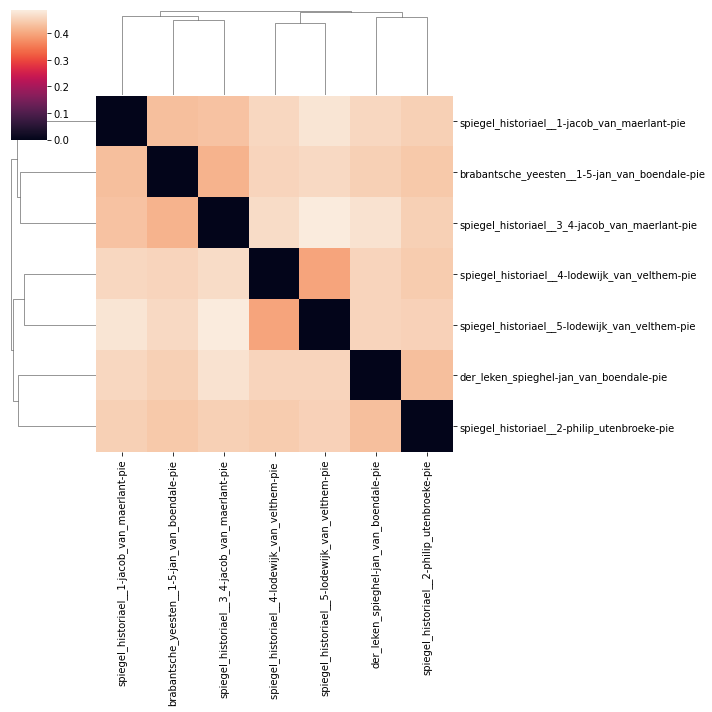

In [84]:
seaborn.clustermap(get_cluster_per_text (cluster_frame), figsize=(10,10))

Obtaining extra statistics again:

In [85]:
dev["unique_rhyme"] = dev['segments'].apply(get_unique_rhyme)
stat = dev.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

title  \
file                                                                                                 
brabantsche_yeesten__1-5-jan_van_boendale-pie    brabantsche_yeesten__1-1brabantsche_yeesten__1...   
der_leken_spieghel-jan_van_boendale-pie          der_leken_spieghel-1der_leken_spieghel-2der_le...   
spiegel_historiael__1-jacob_van_maerlant-pie     spiegel_historiael__1-1spiegel_historiael__1-2...   
spiegel_historiael__2-philip_utenbroeke-pie      spiegel_historiael__2-1spiegel_historiael__2-2...   
spiegel_historiael__3_4-jacob_van_maerlant-pie   spiegel_historiael__3_4-1spiegel_historiael__3...   
spiegel_historiael__4-lodewijk_van_velthem-pie   spiegel_historiael__4-1spiegel_historiael__4-2...   
spiegel_historiael__5-lodewijk_van_velthem-pie   spiegel_historiael__5-1spiegel_historiael__5-2...   

                                                                                            author  \
file                                                                                                 
brabantsche_yeesten__1-5-jan_van_boendale-pie    jan_van_boendalejan_van_boendalejan_van_boenda...   
der_leken_spieghel-jan_van_boendale-pie          jan_van_boendalejan_van_boendalejan_van_boenda...   
spiegel_historiael__1-jacob_van_maerlant-pie     jacob_van_maerlantjacob_van_maerlantjacob_van_...   
spiegel_historiael__2-philip_utenbroeke-pie      philip_utenbroekephilip_utenbroekephilip_utenb...   
spiegel_historiael__3_4-jacob_van_maerlant-pie   jacob_van_maerlantjacob_van_maerlantjacob_van_...   
spiegel_historiael__4-lodewijk_van_velthem-pie   lodewijk_van_velthemlodewijk_van_velthemlodewi...   
spiegel_historiael__5-lodewijk_van_velthem-pie   lodewijk_van_velthemlodewijk_van_velthemlodewi...   

                                                                                          segments  \
file                                                                                                 
brabantsche_yeesten__1-5-jan_van_boendale-pie    om$adp() dat$pron(dem) van$adp() X de$art(def)...   
der_leken_spieghel-jan_van_boendale-pie          omdat$conj(subord) ik$pron(pers,1,sing) niet$a...   
spiegel_historiael__1-jacob_van_maerlant-pie     de$art(def) eerst$num(ord) boek$n(sing) nemen$...   
spiegel_historiael__2-philip_utenbroeke-pie      de$art(def) eerst$num(ord) boek$n(sing) die$pr...   
spiegel_historiael__3_4-jacob_van_maerlant-pie   nu$adv(dem) gaan$v(fin,pres,lex) de$art(def) d...   
spiegel_historiael__4-lodewijk_van_velthem-pie   dat$pron(dem) in$adp() raad$n(sing) toen$adv(d...   
spiegel_historiael__5-lodewijk_van_velthem-pie   de$art(def) vader$n(sing) die$pron(rel) al$adv...   

                                                                                      unique_rhyme  \
file                                                                                                 
brabantsche_yeesten__1-5-jan_van_boendale-pie    [voren, verstaan, geest, wijs, begin, danken, ...   
der_leken_spieghel-jan_van_boendale-pie          [zee, ledigheid, 27, wet, verstaan, lof, 6, da...   
spiegel_historiael__1-jacob_van_maerlant-pie     [wijl, 27, wet, 6, vier, begin, twaalf, 13, tw...   
spiegel_historiael__2-philip_utenbroeke-pie      [voren, victorie, deze, 52, 76, kond, ledighei...   
spiegel_historiael__3_4-jacob_van_maerlant-pie   [noemen, deze, aannemen, 27, verstaan, 6, begi...   
spiegel_historiael__4-lodewijk_van_velthem-pie   [voren, deze, kond, verstaan, gezel, voor, wee...   
spiegel_historiael__5-lodewijk_van_velthem-pie   [voren, zee, noemen, gedicht, onder, beschiete...   

                                                 unique_rhyme_amount  
file                                                                  
brabantsche_yeesten__1-5-jan_van_boendale-pie                   1860  
der_leken_spieghel-jan_van_boendale-pie                         2344  
spiegel_historiael__1-jacob_van_maerlant-pie                    2798  
spiegel_historiael__2-philip_utenbroeke-pie                   

In [86]:
dev["rhyme"] = dev['segments'].apply(get_verse)
stat = dev.groupby('file').agg(sum)
stat

rhyme
file                                                  
brabantsche_yeesten__1-5-jan_van_boendale-pie    16111
der_leken_spieghel-jan_van_boendale-pie          21823
spiegel_historiael__1-jacob_van_maerlant-pie     31966
spiegel_historiael__2-philip_utenbroeke-pie      34472
spiegel_historiael__3_4-jacob_van_maerlant-pie   57732
spiegel_historiael__4-lodewijk_van_velthem-pie    6667
spiegel_historiael__5-lodewijk_van_velthem-pie   19034

## Verification (based on the previous model)

Applying the verification to the possible oeuvre of Hendrik van Brussel:

In [87]:
test_directory = 'hendrik'

test_documents, test_authors, test_titles, test_file_names = load_directory(test_directory, 1698, no_proper_names=True)
test_documents, test_authors, test_titles, test_file_names

test = {'title': test_titles, 'author': test_authors, 'file': test_file_names, 'segments': test_documents}
test = pd.DataFrame(data=test)
test

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]


title               author  \
0    (korte)_roman_van_cassamus-1  hendrik_van_brussel   
1    (korte)_roman_van_cassamus-2  hendrik_van_brussel   
2    (korte)_roman_van_cassamus-3  hendrik_van_brussel   
3    (korte)_roman_van_cassamus-4  hendrik_van_brussel   
4    (korte)_roman_van_cassamus-5  hendrik_van_brussel   
..                            ...                  ...   
125         roman_van_limborch-69  hendrik_van_brussel   
126         roman_van_limborch-70  hendrik_van_brussel   
127         roman_van_limborch-71  hendrik_van_brussel   
128         roman_van_limborch-72  hendrik_van_brussel   
129         roman_van_limborch-73  hendrik_van_brussel   

                                                  file  \
0    (korte)_roman_van_cassamus-hendrik_van_brussel...   
1    (korte)_roman_van_cassamus-hendrik_van_brussel...   
2    (korte)_roman_van_cassamus-hendrik_van_brussel...   
3    (korte)_roman_van_cassamus-hendrik_van_brussel...   
4    (korte)_roman_van_cassamus-hendrik_van_brussel...   
..                                                 ...   
125         roman_van_limborch-hendrik_van_brussel-pie   
126         roman_van_limborch-hendrik_van_brussel-pie   
127         roman_van_limborch-hendrik_van_brussel-pie   
128         roman_van_limborch-hendrik_van_brussel-pie   
129         roman_van_limborch-hendrik_van_brussel-pie   

                                              segments  
0    X/ na$adp() die$pron(dem) dat$conj(subord) de$...  
1    op$adp() een$art(indef) rivier$n(sing)/ en$con...  
2    negeen$pron(indef) ontzeggen$v(fin,past,lex)/ ...  
3    te+wij+waart$adp()+pron(pers,1,plu)+adp() kome...  
4    kracht$n(sing) daar$pronadv(dem) mede$pronadv(...  
..                                                 ...  
125  ik$pron(pers,1,sing) mogen$v(fin,pres,aux_cop)...  
126  de$art(def) weg$n(sing) iet$pron(indef) togen$...  
127  groot$adj() plein$n(sing) zij$pron(pers,3,plu)...  
128  komen$v(participle,pres) verzien$v(infin)/ en$...  
129  komen$v(fin,pres,lex) van$adp() de$moe X de$ar...  

[130 rows x 4 columns]

In [88]:
test_X = rhyme_vectorizer.transform(test['segments']).toarray() # use the fitted vectorizer

test_result_SA, test_result_DA, test_clustermap = calibrator.calculate_distance(test, test_X) # use the calibrator defined previously
test_result_SA, test_result_DA

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:42<00:00,  2.31s/it]


([0.4359469039357283,
  0.3836922648108763,
  0.39188015037937074,
  0.4382272012616016,
  0.4835749793468371,
  0.41702152174013524,
  0.4080073133765303,
  0.3839940763512378,
  0.4484164963326976,
  0.46468156395624205,
  0.44370360667044595,
  0.4231897558923994,
  0.4250693088885044,
  0.40097671411099756,
  0.3953844680234757,
  0.4209869874713878,
  0.4756735427570025,
  0.3540822548505033,
  0.4217969636676008,
  0.3928613573189234,
  0.38909408325256395,
  0.47897511268773446,
  0.4465111432823443,
  0.40749044712522814,
  0.44253043864111924,
  0.4195528713955622,
  0.42592132020566803,
  0.37000998747887953,
  0.42167067339015546,
  0.42515291821602885,
  0.3970025492429592,
  0.4442690882575307,
  0.409532012869398,
  0.4432748727912312,
  0.516708426856377,
  0.3750769786894301,
  0.41352788820812836,
  0.4061498048717818,
  0.3972506601542522,
  0.42255534623419844,
  0.38525835397762603,
  0.42058680395683884,
  0.48407648815842774,
  0.47639970703417384,
  0.40331853275

The average distances (we want to examine whether the works were written by the same author, so we only calculate one value now. Do not mind the names of the variables):

In [89]:
test_avg_SA = sum(test_result_SA)/len(test_result_SA)
print(round(test_avg_SA, 4))
test_avg_DA = sum(test_result_DA)/len(test_result_DA)
print(round(test_avg_DA, 4))

0.4197
0.0


The median distances:

In [90]:
print(statistics.median(test_result_SA))
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.41698983443885473
0.4289093933952588
0.44570773677566733


A boxplot with the distribution of the cosine distances:

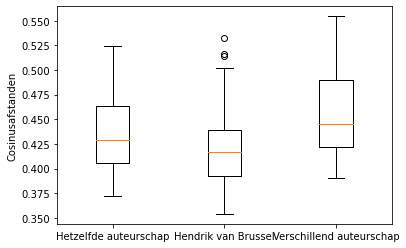

In [91]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, test_result_SA, result_DA])
ax.set(xticklabels=('Hetzelfde auteurschap', 'Hendrik van Brussel', 'Verschillend auteurschap'), ylabel='Cosinusafstanden');

Creating a clustermap of the works and their distances:

In [92]:
test_cluster_frame = pd.DataFrame(data=test_clustermap)
test_cluster_frame = test_cluster_frame.set_index(test['file'])
test_cluster_frame.set_axis(test["file"].values.tolist(), axis=1, inplace=True)
test_cluster_frame

(korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.405688    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.470009    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.429278    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.450212    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.531544    

                                                    (korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.294774    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.278440    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.346312    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.370948    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.464079    

                                                    (korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.421603    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.412040    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.223699    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.412440    
roman_van_limborch-hen

C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


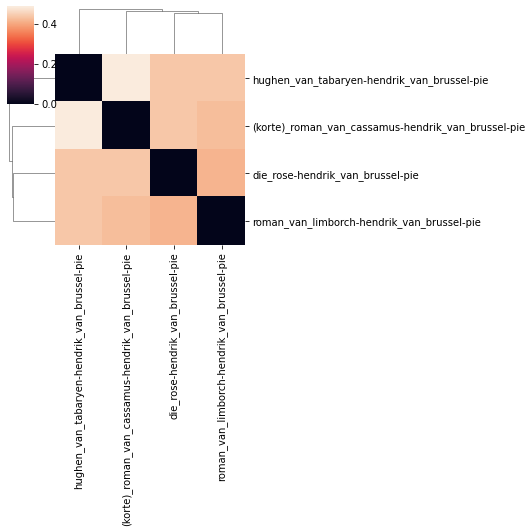

In [93]:
seaborn.clustermap(get_cluster_per_text(test_cluster_frame), figsize=(7.5, 7.5))

## Calibration for "*Lancelot-compilatie*"

Loading in the calibration corpus:

In [94]:
documents, authors, titles, file_names = load_directory('lancelot', 1698, no_proper_names=True)
authors, titles, file_names

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]


(['onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onb

In [95]:
titles[38]

'arturs_doet-39'

In [96]:
documents[38]

'hij$pron(pers,3,sing) zegenen$v(fin,past,lex) en$conj(coord) kruisen$v(fin,past,lex) hij$pron(pers,3,sing) zoetelijk$adv(gener)/ en$conj(coord) zeggen$v(fin,past,lex) ai$interj() heer$n(sing) van$adp() hemelrijk$n(sing)/ die$pron(rel) ik$pron(pers,1,sing) hebben$v(fin,pres,aux_cop) togen$v(participle,past) en$conj(coord) geven$v(participle,past)/ veel$num(indef) eren$n(sing) in$adp() dit$pron(dem) aards$adj() leven$n(sing)/ sident$adv(gener) dat$conj(subord) ik$pron(pers,1,sing) eerst$adv(gener) dragen$v(fin,past,lex) kroon$n(sing)/ en$conj(coord) het$pron(pers,3,sing) ik$pron(pers,1,sing) vallen$v(fin,past,lex) zo$adv(resum) schoon$adj()/ dat$conj(subord) ik$pron(pers,1,sing) de$adp() te$art(def) land$n(sing) komen$v(fin,past,lex) de$art(def) en$conj(coord) eer$n(sing)/ te$adp() houden$v(infin) dat$pron(dem) zijn$v(fin,past,aux_cop) bij$adp() gij$pron(poss) heer$n(sing)/ en$conj(coord) al$adv(gener) bij$adp() de$art(def) genade$n(sing) van$adp() gij$pron(pers,2,sing)/ zoet$adj() heer

Creating a data frame with all of the information regarding the text segments:

In [97]:
dev = {'title': titles, 'author': authors, 'file': file_names, 'segments': documents}
dev = pd.DataFrame(data=dev)
dev

title    author                            file  \
0           arturs_doet-1  onbekend        arturs_doet-onbekend-pie   
1           arturs_doet-2  onbekend        arturs_doet-onbekend-pie   
2           arturs_doet-3  onbekend        arturs_doet-onbekend-pie   
3           arturs_doet-4  onbekend        arturs_doet-onbekend-pie   
4           arturs_doet-5  onbekend        arturs_doet-onbekend-pie   
..                    ...       ...                             ...   
301   wrake_van_ragisel-8  onbekend  wrake_van_ragisel-onbekend-pie   
302   wrake_van_ragisel-9  onbekend  wrake_van_ragisel-onbekend-pie   
303  wrake_van_ragisel-10  onbekend  wrake_van_ragisel-onbekend-pie   
304  wrake_van_ragisel-11  onbekend  wrake_van_ragisel-onbekend-pie   
305  wrake_van_ragisel-12  onbekend  wrake_van_ragisel-onbekend-pie   

                                              segments  
0    men$pron(indef) zeggen$v(fin,pres,lex) dat$con...  
1    in$adp() zulk$pron(dem) zin$n(sing)/ dat$conj(...  
2    zijn$v(fin,past,aux_cop) te$pron(dem) die$adp(...  
3    en$conj(coord) X zijn$v(fin,pres,aux_cop) over...  
4    klaar$adj()/ toen$adv(dem) spreken$v(fin,past,...  
..                                                 ...  
301  zien$v(fin,past,aux_cop) toe$pronadv(prep)/ en...  
302  kasteel$n(sing)/ heten+hij+men$v(fin,past,lex)...  
303  die$pron(rel) zijn$pron(poss) zwaard$n(sing) k...  
304  mede$pronadv(prep) de$te de$art(def) stad$n(si...  
305  min$adv(gener) no$conj(coord) mee$num(indef)/ ...  

[306 rows x 4 columns]

Obtaining the amount of segments for each text:

In [98]:
for file in dev['file'].unique():
    print(file)
    print(len(dev[dev["file"] == file]))

arturs_doet-onbekend-pie
46
lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie
2
queeste_van_den_grale-onbekend-pie
39
roman_van_den_riddere_metter_mouwen-onbekend-pie
14
roman_van_lancelot-onbekend-pie
133
roman_van_moriaen-onbekend-pie
16
roman_van_perchevael-onbekend-pie
19
roman_van_torec-onbekend-pie
13
walewein_ende_keye-onbekend-pie
12
wrake_van_ragisel-onbekend-pie
12


Features for the vectorizer:

In [99]:
rhyme_words_all = {'use_idf': False,
          'max_features':100,
          'analyzer': 'word',
          'token_pattern': r"([^ ]*)\/",
#           'min_df': 2,
          'norm': 'l1', 
          'ngram_range': (1, 1)}

In [100]:
rhyme_vectorizer = TfidfVectorizer(**rhyme_words_all)

Fitting and tranforming:

In [101]:
dev_X = rhyme_vectorizer.fit_transform(dev['segments']).toarray()

The number of segments in the first spot and the amount of features in the second spot:

In [102]:
dev_X.shape

(306, 100)

Using the "Calibrator":

In [103]:
calibrator = Calibrator(iters=200, rnd_prop=0.5) # 200 iterations based on 50% of the features

In [104]:
result_SA, result_DA, clustermap = calibrator.calculate_distance(dev, dev_X)
result_SA, result_DA 

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [46:06<00:00, 13.83s/it]


([0.39409853031352166,
  0.43118973323069976,
  0.3731118627468119,
  0.38232071079974755,
  0.44084198187840207,
  0.40860739306813043,
  0.38268819529980797,
  0.3809058845414725,
  0.40808202081317424,
  0.4175275561994449,
  0.41476768484691645,
  0.4110296071094573,
  0.4899810469961082,
  0.44275032959120003,
  0.41717582882570453,
  0.4743097541458542,
  0.40785730870467674,
  0.4081829760854787,
  0.402571318474461,
  0.406545920482393,
  0.4200069977659442,
  0.491443746682776,
  0.4280459167944658,
  0.4676429752071447,
  0.4141761208081793,
  0.3838066421407409,
  0.5203831142037815,
  0.4736332026071725,
  0.391014676821154,
  0.38779232979682116,
  0.41473623876088817,
  0.47784634814762433,
  0.4226093224956585,
  0.45760615170801217,
  0.423084349375457,
  0.41676126521714835,
  0.41465556142648446,
  0.40888870887225476,
  0.4247729571636725,
  0.4926249887115391,
  0.4487110773679486,
  0.4830672594111349,
  0.4248476703790839,
  0.42280932537218613,
  0.41190467884519

The average distance (we actually calculate the DA distance here, do not mind the name of the variable):

In [105]:
avg_SA = sum(result_SA)/len(result_SA)
print(round(avg_SA, 4))

0.4251


The median distance:

In [106]:
print(statistics.median(result_SA))

0.41846547287125263


A boxplot with the distribution of the cosine distances between DA pairs (the model sees this as SA pairs, since the author names are the same (onbekend), that is why the label of the bowplot is differrent):

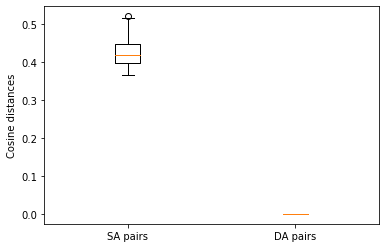

In [107]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, result_DA])
ax.set(xticklabels=('SA pairs', 'DA pairs'), ylabel='Cosine distances');

A clustermap of the works and their distances. 

In [108]:
cluster_frame = pd.DataFrame(data=clustermap)
cluster_frame = cluster_frame.set_index(dev['file'])
cluster_frame.set_axis(dev["file"].values.tolist(), axis=1, inplace=True)
cluster_frame

arturs_doet-onbekend-pie  \
file                                                       
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
...                                                  ...   
wrake_van_ragisel-onbekend-pie                  0.621427   
wrake_van_ragisel-onbekend-pie                  0.646444   
wrake_van_ragisel-onbekend-pie                  0.626722   
wrake_van_ragisel-onbekend-pie                  0.527684   
wrake_van_ragisel-onbekend-pie                  0.517875   

                                arturs_doet-onbekend-pie  \
file                                                       
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
...                                                  ...   
wrake_van_ragisel-onbekend-pie                  0.555744   
wrake_van_ragisel-onbekend-pie                  0.604781   
wrake_van_ragisel-onbekend-pie                  0.572045   
wrake_van_ragisel-onbekend-pie                  0.496933   
wrake_van_ragisel-onbekend-pie                  0.545558   

                                arturs_doet-onbekend-pie  \
file                                                       
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
...                                                  ...   
wrake_van_ragisel-onbekend-pie                  0.351086   
wrake_van_ragisel-onbekend-pie                  0.319026   
wrake_van_ragisel-onbekend-pie                  0.384239   
wrake_van_ragisel-onbekend-pie                  0.381149   
wrake_van_ragisel-onbekend-pie                  0.332953   

                                arturs_doet-onbekend-pie  \
file                                                       
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
...                                                  ...   
wrake_van_ragisel-onbekend-pie                  0.324964   
wrake_van_ragisel-onbekend-pie                  0.346504   
wrake_van_ragisel-onbekend-pie                  0.373917   
wrake_van_ragisel-onbekend-pie                  0.358545   
wrake_van_ragisel-onbekend-pie                  0.377384   

                                arturs_doet-onbekend-pie  \
file                                                       
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
arturs_doet-onbekend-pie                        0.000000   
...                                                  ...   
wrake_van_ragisel-onbekend-pie                  0.434681   
wrake_van_ragisel-onbekend-pie                  0.437956   
wrake_van_ragisel-onbekend-pie                  0.479842   
wrake_van_ragisel-onbekend-pie                  0.495842   
wrake_van_ragisel-onbekend-pie                  0.452802   

                                arturs_doet-onbekend-pie  \
file                                                       
arturs_

In [109]:
get_cluster_per_text (cluster_frame)

arturs_doet-onbekend-pie  \
arturs_doet-onbekend-pie                                            0.000000   
lanceloet_en_het_hert_met_de_witte_voet-onbeken...                  0.504138   
queeste_van_den_grale-onbekend-pie                                  0.406758   
roman_van_den_riddere_metter_mouwen-onbekend-pie                    0.441360   
roman_van_lancelot-onbekend-pie                                     0.401607   
roman_van_moriaen-onbekend-pie                                      0.522926   
roman_van_perchevael-onbekend-pie                                   0.430062   
roman_van_torec-onbekend-pie                                        0.430415   
walewein_ende_keye-onbekend-pie                                     0.413472   
wrake_van_ragisel-onbekend-pie                                      0.416833   

                                                    lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie  \
arturs_doet-onbekend-pie                                                                     0.504138      
lanceloet_en_het_hert_met_de_witte_voet-onbeken...                                           0.000000      
queeste_van_den_grale-onbekend-pie                                                           0.492756      
roman_van_den_riddere_metter_mouwen-onbekend-pie                                             0.453864      
roman_van_lancelot-onbekend-pie                                                              0.476846      
roman_van_moriaen-onbekend-pie                                                               0.461284      
roman_van_perchevael-onbekend-pie                                                            0.477707      
roman_van_torec-onbekend-pie                                                                 0.479064      
walewein_ende_keye-onbekend-pie                                                              0.441537      
wrake_van_ragisel-onbekend-pie                                                               0.459350      

                                                    queeste_van_den_grale-onbekend-pie  \
arturs_doet-onbekend-pie                                                      0.406758   
lanceloet_en_het_hert_met_de_witte_voet-onbeken...                            0.492756   
queeste_van_den_grale-onbekend-pie                                            0.000000   
roman_van_den_riddere_metter_mouwen-onbekend-pie                              0.464789   
roman_van_lancelot-onbekend-pie                                               0.348197   
roman_van_moriaen-onbekend-pie                                                0.552736   
roman_van_perchevael-onbekend-pie                                             0.438503   
roman_van_torec-onbekend-pie                                                  0.431499   
walewein_ende_keye-onbekend-pie                                               0.434017   
wrake_van_ragisel-onbekend-pie                                                0.431395   

                                                    roman_van_den_riddere_metter_mouwen-onbekend-pie  \
arturs_doet-onbekend-pie                                                                    0.441360   
lanceloet_en_het_hert_met_de_witte_voet-onbeken...                                          0.453864   
queeste_van_den_grale-onbekend-pie                                                          0.464789   
roman_van_den_riddere_metter_mouwen-onbekend-pie                                            0.000000   
roman_van_lancelot-onbekend-pie                                                             0.463722   
roman_van_moriaen-onbekend-pie                                                              0.474791   
roman_van_perchevael-onbekend-pie                                                           0.377093   
roman_van_torec-onbekend-pie                                                                0.374463   
walewein_ende_keye-onbekend-pie                        

C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


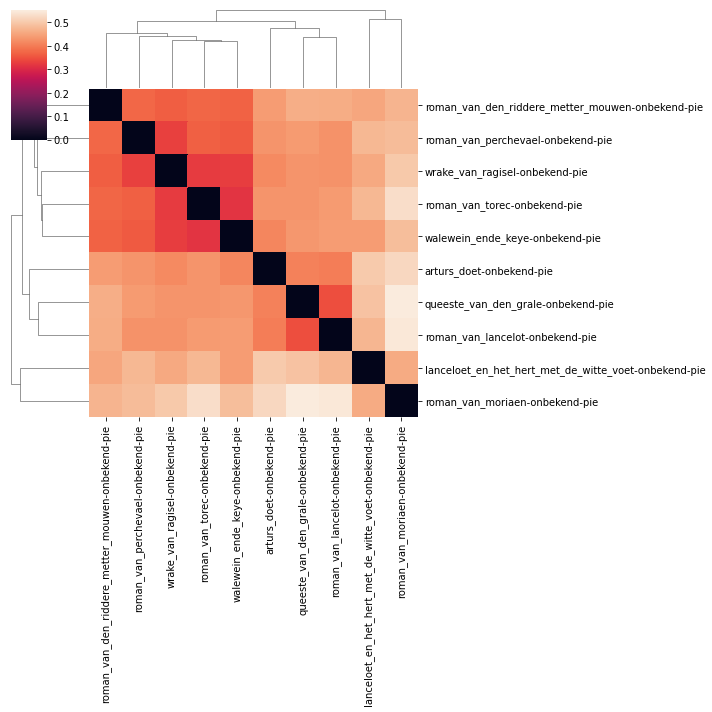

In [110]:
seaborn.clustermap(get_cluster_per_text (cluster_frame), figsize=(10,10))

Obtaining extra statistics again

In [111]:
dev["unique_rhyme"] = dev['segments'].apply(get_unique_rhyme)
stat = dev.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

title  \
file                                                                                                    
arturs_doet-onbekend-pie                            arturs_doet-1arturs_doet-2arturs_doet-3arturs_...   
lanceloet_en_het_hert_met_de_witte_voet-onbeken...  lanceloet_en_het_hert_met_de_witte_voet-1lance...   
queeste_van_den_grale-onbekend-pie                  queeste_van_den_grale-1queeste_van_den_grale-2...   
roman_van_den_riddere_metter_mouwen-onbekend-pie    roman_van_den_riddere_metter_mouwen-1roman_van...   
roman_van_lancelot-onbekend-pie                     roman_van_lancelot-1roman_van_lancelot-2roman_...   
roman_van_moriaen-onbekend-pie                      roman_van_moriaen-1roman_van_moriaen-2roman_va...   
roman_van_perchevael-onbekend-pie                   roman_van_perchevael-1roman_van_perchevael-2ro...   
roman_van_torec-onbekend-pie                        roman_van_torec-1roman_van_torec-2roman_van_to...   
walewein_ende_keye-onbekend-pie                     walewein_ende_keye-1walewein_ende_keye-2walewe...   
wrake_van_ragisel-onbekend-pie                      wrake_van_ragisel-1wrake_van_ragisel-2wrake_va...   

                                                                                               author  \
file                                                                                                    
arturs_doet-onbekend-pie                            onbekendonbekendonbekendonbekendonbekendonbeke...   
lanceloet_en_het_hert_met_de_witte_voet-onbeken...                                   onbekendonbekend   
queeste_van_den_grale-onbekend-pie                  onbekendonbekendonbekendonbekendonbekendonbeke...   
roman_van_den_riddere_metter_mouwen-onbekend-pie    onbekendonbekendonbekendonbekendonbekendonbeke...   
roman_van_lancelot-onbekend-pie                     onbekendonbekendonbekendonbekendonbekendonbeke...   
roman_van_moriaen-onbekend-pie                      onbekendonbekendonbekendonbekendonbekendonbeke...   
roman_van_perchevael-onbekend-pie                   onbekendonbekendonbekendonbekendonbekendonbeke...   
roman_van_torec-onbekend-pie                        onbekendonbekendonbekendonbekendonbekendonbeke...   
walewein_ende_keye-onbekend-pie                     onbekendonbekendonbekendonbekendonbekendonbeke...   
wrake_van_ragisel-onbekend-pie                      onbekendonbekendonbekendonbekendonbekendonbeke...   

                                                                                             segments  \
file                                                                                                    
arturs_doet-onbekend-pie                            men$pron(indef) zeggen$v(fin,pres,lex) dat$con...   
lanceloet_en_het_hert_met_de_witte_voet-onbeken...  avontuur$art(def) de$n(sing) vertellen$v(fin,p...   
queeste_van_den_grale-onbekend-pie                  een$art(indef) schoon$adj() avontuur$n(sing) h...   
roman_van_den_riddere_metter_mouwen-onbekend-pie    wij$pron(pers,1,plu) vertellen$v(fin,pres,lex)...   
roman_van_lancelot-onbekend-pie                     god$n(sing) die$art(def) maker$n(sing) zijn$v(...   
roman_van_moriaen-onbekend-pie                      wij$pron(pers,1,plu) maken$v(fin,pres,lex) kon...   
roman_van_perchevael-onbekend-pie                   avontuur$art(def) de$n(sing) gewagen$v(fin,pre...   
roman_van_torec-onbekend-pie                        de$art(def) avontuur$n(sing) doen$v(fin,pres,l...   
walewein_ende_keye-onbekend-pie                     de$art(def) avontuur$n(sing) doen$v(fin,pres,l...   
wrake_van_ragisel-onbekend-pie                      wij$pron(pers,1,plu) zeggen$v(fin,pres,lex) hi...   

                                                                                         unique_rhyme  \
file                                                                                                    
arturs_doet-onbekend-pie                            [voren, minne, schoonheid, deze, aannemen, ver...  

In [112]:
dev["rhyme"] = dev['segments'].apply(get_verse)
stat = dev.groupby('file').agg(sum)
stat

rhyme
file                                                     
arturs_doet-onbekend-pie                            12865
lanceloet_en_het_hert_met_de_witte_voet-onbeken...    580
queeste_van_den_grale-onbekend-pie                  10911
roman_van_den_riddere_metter_mouwen-onbekend-pie     3854
roman_van_lancelot-onbekend-pie                     36735
roman_van_moriaen-onbekend-pie                       4610
roman_van_perchevael-onbekend-pie                    5321
roman_van_torec-onbekend-pie                         3575
walewein_ende_keye-onbekend-pie                      3385
wrake_van_ragisel-onbekend-pie                       3347

# Verification (based on the previous model)

Applying the verification to the possible oeuvre of Hendrik van Brussel:

In [113]:
test_directory = 'hendrik'

test_documents, test_authors, test_titles, test_file_names = load_directory(test_directory, 1698, no_proper_names=True)
test_documents, test_authors, test_titles, test_file_names

test = {'title': test_titles, 'author': test_authors, 'file': test_file_names, 'segments': test_documents}
test = pd.DataFrame(data=test)
test

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]


title               author  \
0    (korte)_roman_van_cassamus-1  hendrik_van_brussel   
1    (korte)_roman_van_cassamus-2  hendrik_van_brussel   
2    (korte)_roman_van_cassamus-3  hendrik_van_brussel   
3    (korte)_roman_van_cassamus-4  hendrik_van_brussel   
4    (korte)_roman_van_cassamus-5  hendrik_van_brussel   
..                            ...                  ...   
125         roman_van_limborch-69  hendrik_van_brussel   
126         roman_van_limborch-70  hendrik_van_brussel   
127         roman_van_limborch-71  hendrik_van_brussel   
128         roman_van_limborch-72  hendrik_van_brussel   
129         roman_van_limborch-73  hendrik_van_brussel   

                                                  file  \
0    (korte)_roman_van_cassamus-hendrik_van_brussel...   
1    (korte)_roman_van_cassamus-hendrik_van_brussel...   
2    (korte)_roman_van_cassamus-hendrik_van_brussel...   
3    (korte)_roman_van_cassamus-hendrik_van_brussel...   
4    (korte)_roman_van_cassamus-hendrik_van_brussel...   
..                                                 ...   
125         roman_van_limborch-hendrik_van_brussel-pie   
126         roman_van_limborch-hendrik_van_brussel-pie   
127         roman_van_limborch-hendrik_van_brussel-pie   
128         roman_van_limborch-hendrik_van_brussel-pie   
129         roman_van_limborch-hendrik_van_brussel-pie   

                                              segments  
0    X/ na$adp() die$pron(dem) dat$conj(subord) de$...  
1    op$adp() een$art(indef) rivier$n(sing)/ en$con...  
2    negeen$pron(indef) ontzeggen$v(fin,past,lex)/ ...  
3    te+wij+waart$adp()+pron(pers,1,plu)+adp() kome...  
4    kracht$n(sing) daar$pronadv(dem) mede$pronadv(...  
..                                                 ...  
125  ik$pron(pers,1,sing) mogen$v(fin,pres,aux_cop)...  
126  de$art(def) weg$n(sing) iet$pron(indef) togen$...  
127  groot$adj() plein$n(sing) zij$pron(pers,3,plu)...  
128  komen$v(participle,pres) verzien$v(infin)/ en$...  
129  komen$v(fin,pres,lex) van$adp() de$moe X de$ar...  

[130 rows x 4 columns]

In [114]:
test_X = rhyme_vectorizer.transform(test['segments']).toarray() # use the fitted vectorizer

test_result_SA, test_result_DA, test_clustermap = calibrator.calculate_distance(test, test_X) # use the calibrator defined previously
test_result_SA, test_result_DA

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:50<00:00,  2.35s/it]


([0.48281452994639806,
  0.45323849995977017,
  0.4429909653361109,
  0.3726039386963443,
  0.3657168263661999,
  0.44618256167952397,
  0.42730600400431473,
  0.36624751140232514,
  0.45800514116099045,
  0.4614561123499163,
  0.36233567270271233,
  0.3699052203183791,
  0.39067187140621024,
  0.36642172560691616,
  0.36417887488467887,
  0.4220622067066467,
  0.5077324083698667,
  0.37327343608076435,
  0.3734438149982804,
  0.3699985382292621,
  0.379508467757899,
  0.4545703680989724,
  0.3583805407131204,
  0.44881614159853345,
  0.48919888788691046,
  0.4972042387033134,
  0.3787757537930129,
  0.37038042569123947,
  0.3750214077192211,
  0.4659004640436934,
  0.47674437192466645,
  0.526232782810891,
  0.49431586717723797,
  0.38074004896159125,
  0.3705421314751671,
  0.3810002442035908,
  0.4661296439865462,
  0.4264109829365021,
  0.49937864711851176,
  0.36588658826231024,
  0.464335587831671,
  0.36464917138476155,
  0.3728585827079892,
  0.38233441150323966,
  0.3639347544

The average distances (we want to examine whether the works were written by the same author, so we only calculate one value now. Do not mind the names of the variables):

In [115]:
test_avg_SA = sum(test_result_SA)/len(test_result_SA)
print(round(test_avg_SA, 4))
test_avg_DA = sum(test_result_DA)/len(test_result_DA)
print(round(test_avg_DA, 4))

0.4154
0.0


The median distances:

In [116]:
print(statistics.median(test_result_SA))
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.3881434626267648
0.41846547287125263
0.0


A boxplot with the distribution of the cosine distances:

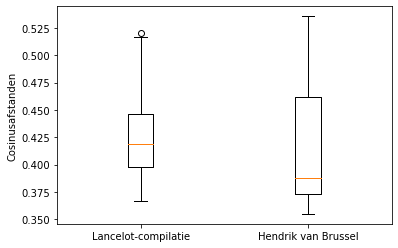

In [117]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, test_result_SA])
ax.set(xticklabels=('Lancelot-compilatie', 'Hendrik van Brussel'), ylabel='Cosinusafstanden');

Creating a clustermap of the works and their distances. 

In [118]:
test_cluster_frame = pd.DataFrame(data=test_clustermap)
test_cluster_frame = test_cluster_frame.set_index(test['file'])
test_cluster_frame.set_axis(test["file"].values.tolist(), axis=1, inplace=True)
test_cluster_frame

(korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.505823    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.288506    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.225927    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.303096    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.340222    

                                                    (korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.360167    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.245224    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.177175    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.254715    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.301599    

                                                    (korte)_roman_van_cassamus-hendrik_van_brussel-pie  \
file                                                                                                     
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
(korte)_roman_van_cassamus-hendrik_van_brussel-pie                                           0.000000    
...                                                                                               ...    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.524567    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.308877    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.155575    
roman_van_limborch-hendrik_van_brussel-pie                                                   0.316002    
roman_van_limborch-hen

C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


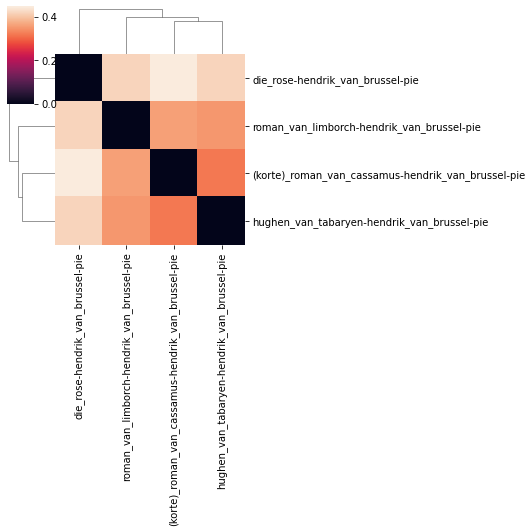

In [119]:
seaborn.clustermap(get_cluster_per_text(test_cluster_frame), figsize=(7.5, 7.5))